## Постановка задачи:

Есть датасет, который был получен путем анализа задержек между переходами пользователя по страницам портала N. Датасет представляет собой сохраненный утилитой joblib список из кортежей, которые, в свою очередь, выглядят так:

( <идентификатор сессии>, <словарь переходов и их дельт в исследуемой сессии>, <словарь переходов и их дельт в истории пользователя> )
```Пример кортежа:
(
 'fe5dbbcea5ce7e2988b8c69bcfdfde8904aabc1f',
    {
        '84,297': 46.8, 
        '257,32': 7.2,
    },
    {
        '257,32': [7.902, 15.038, 7.54, 8.0],
        '84,297': [4.896, 5.163, 9.1, 4.603, 6.373, 4.925, 7.3, 11.383] }
)```

Необходимо найти такие сессии, в которых > 50% переходов не характерны истории пользователя. Не характерными считаются те переходы, задержки которых в исследуемой сессии сильно отличаются от его истории (например, в исследуемой сессии задержка перехода равна 55 сек, тогда как в истории он вел себя так: [1, 1, 3, 4, 2, 1]).

- Доподлино известно, что датасет включает в себя от 17% до 55% (в зависимости от метода оценки) сессий, которые попадают под требуемый критерий (> 50% переходов не характерны).
- Оформление результата: результат работы должен быть оформлен в виде Jupyter Notebook и содержать пояснения к шагам, которые вы предпринимаете. Описать (кратко), почему был выбран тот или иной метод оценки аномальности и, по возможности, привести аналоги данного метода.

PyOD - широкий спектр готовых методов ML, не нужно проверять каждый алгоритм, для поиска аномалии, т.к. в зависимости от данных, некоторые методы работают лучше, некоторые хуже

In [1]:
pip install pyod 

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data
import joblib
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Существует разные подходы для решения задачи обнаружения аномалий


 
![Imgur](https://imgur.com/ELJMqOA.png)

## При решении рассмотрим такие методы как:
- Интерквартильный размах (статистика)
- DBSCAN (кластеризация)
- LOF (Local Outlier Factor) (кластеризация)
- K means (кластеризация)
- PCA (Метод главных компонент)
- Naïve Bayes classifiers (классификация)
- AutoEncoder (нейронная сеть)

Начнем с анализа датасета без ML, используем для этого интерквантильный размах, потому что с его помощью мы сможем определить, попадет ли значение из исследуемой сессии в диапазон исторической 

## Интерквартильный размах

Загрузим и проверим файл с данными

In [3]:
file = joblib.load("dataset.dump")
print(file)

[('974ab4c974716eac64aa7fc9bfeed7ab06413819', {'323,188': 7.334977046892243, '230,338': 32.96108135150341, '369,316': 41.209561596990675, '306,372': 23.082700303788986, '381,191': 1.4749234075548538}, {'323,188': [2.058, 1.789, 2.009, 1.996, 1.833, 1.88, 2.127, 6.529, 2.349, 1.798, 5.969, 2.242, 2.368, 1.89, 1.757, 4.485, 3.122, 1.743, 1.863, 2.564, 4.519, 2.283, 7.157, 1.831, 5.0, 2.0], '230,338': [6.886, 12.094000000000001, 10.171, 11.949000000000002, 14.14, 9.416, 14.536, 14.999, 24.104, 9.863999999999999, 12.657, 18.661, 13.927, 1.348, 1.482, 1.983, 0.846, 7.661, 1.704, 1.619, 0.878, 1.081, 10.667, 13.827000000000002, 16.844, 13.82, 11.518, 19.517, 15.781, 28.221, 49.415, 5.61, 43.035, 8.657], '369,316': [9.129, 17.823, 15.675, 22.265, 12.758000000000001, 17.791, 54.193, 16.93, 21.545, 16.948, 16.675, 29.442000000000004, 14.981999999999998, 27.415, 18.793000000000003, 31.956000000000003, 14.764, 16.398000000000003, 19.671, 27.49, 23.405, 28.451999999999998, 27.450999999999997, 31.0

In [4]:
w = file[0][1]  # Исследуемые значения первой сессии
j = file[0][2]  # История переходов первой сессии
print(w)
print('\n',j)

{'323,188': 7.334977046892243, '230,338': 32.96108135150341, '369,316': 41.209561596990675, '306,372': 23.082700303788986, '381,191': 1.4749234075548538}

 {'323,188': [2.058, 1.789, 2.009, 1.996, 1.833, 1.88, 2.127, 6.529, 2.349, 1.798, 5.969, 2.242, 2.368, 1.89, 1.757, 4.485, 3.122, 1.743, 1.863, 2.564, 4.519, 2.283, 7.157, 1.831, 5.0, 2.0], '230,338': [6.886, 12.094000000000001, 10.171, 11.949000000000002, 14.14, 9.416, 14.536, 14.999, 24.104, 9.863999999999999, 12.657, 18.661, 13.927, 1.348, 1.482, 1.983, 0.846, 7.661, 1.704, 1.619, 0.878, 1.081, 10.667, 13.827000000000002, 16.844, 13.82, 11.518, 19.517, 15.781, 28.221, 49.415, 5.61, 43.035, 8.657], '369,316': [9.129, 17.823, 15.675, 22.265, 12.758000000000001, 17.791, 54.193, 16.93, 21.545, 16.948, 16.675, 29.442000000000004, 14.981999999999998, 27.415, 18.793000000000003, 31.956000000000003, 14.764, 16.398000000000003, 19.671, 27.49, 23.405, 28.451999999999998, 27.450999999999997, 31.012999999999998, 53.006, 22.175, 50.446, 10.75

Выясним общее кол-во сессий в дампе:

In [5]:
len(file)

1536

Создание графиков boxplot для анализа с помощью интерквантильного размаха. Это разность между третьим и первым квартилями. Интерквартильный размах можно использовать для данной задачи, потому что это характеристика разброса распределения величины (аналог дисперсии), что покажет насколько явно исследуемые значения принадлежат или нет исторической выборке. Вместе, медиана и интерквартильный размах могут быть использованы вместо математического ожидания и дисперсии в случае распределений с большими выбросами.

Сессия номер: 0 ;  974ab4c974716eac64aa7fc9bfeed7ab06413819


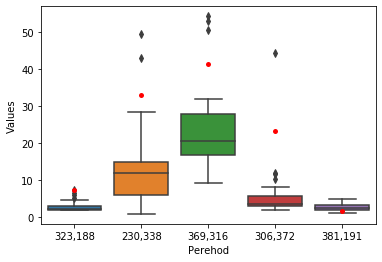

Сессия номер: 1 ;  7d1867122d9eafc204bc63acbd2f589ff9963d8e


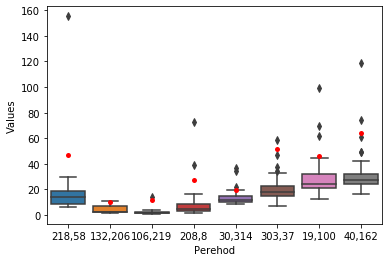

Сессия номер: 2 ;  611c3b4d6ea88f2a4b922d982b4acd2c17f7d8be


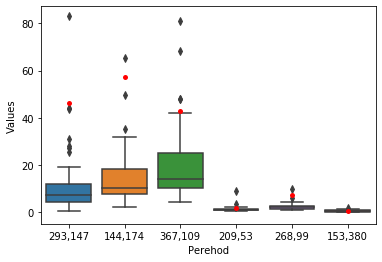

Сессия номер: 3 ;  cf324559d74f4a57dee581c725423aef4e7df203


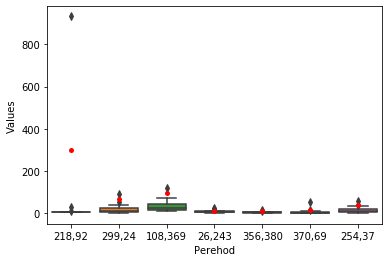

Сессия номер: 4 ;  a2f41ebbb357ee235e9d0a2dddc53c1afebb1e14


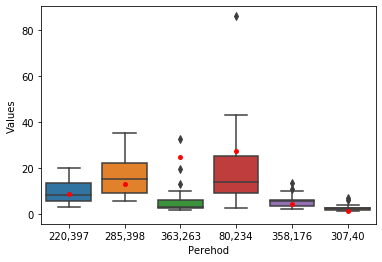

Сессия номер: 5 ;  e3d09d110ffd832db5c5683ac611ac8562dff28d


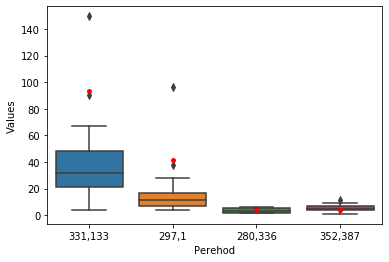

Сессия номер: 6 ;  974ab4c974716eac64aa7fc9bfeed7ab06413819


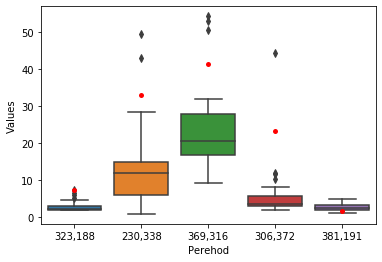

Сессия номер: 7 ;  08a35293e09f508494096c1c1b3819edb9df50db


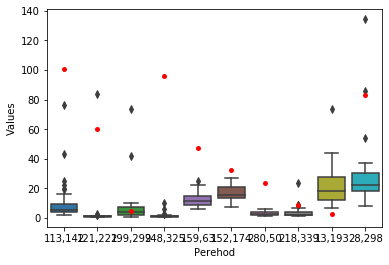

Сессия номер: 8 ;  88a1bd763690de16bab97992eaaf4875a2406bb2


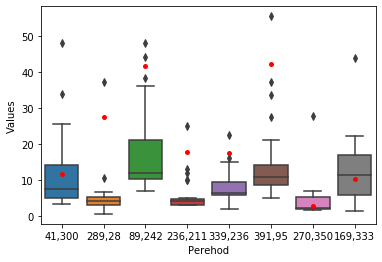

Сессия номер: 9 ;  4d5bc9910525f35dd89b403c678f1b3bfc557f70


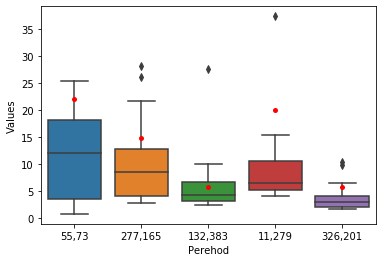

Сессия номер: 10 ;  5f5e53388831c53852da3a2954cb6573642f7fab


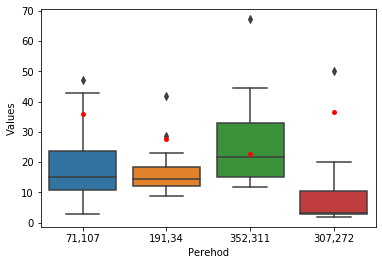

Сессия номер: 11 ;  aa0e9f704b12a27af259750f79b22f99efdb68c5


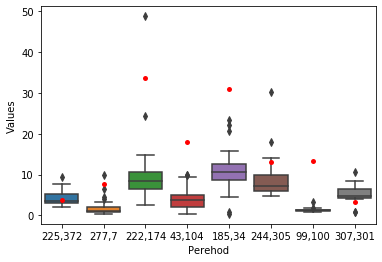

Сессия номер: 12 ;  ea4730ea72c5cd33517ca70f4d84e1fed3c5af9c


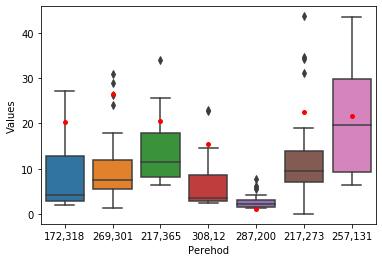

Сессия номер: 13 ;  9f3bdbf605248e180acba43499e6c6cbcec07427


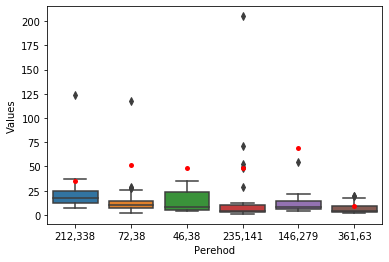

Сессия номер: 14 ;  e3cbba8883fe746c6e35783c9404b4bc0c7ee9eb


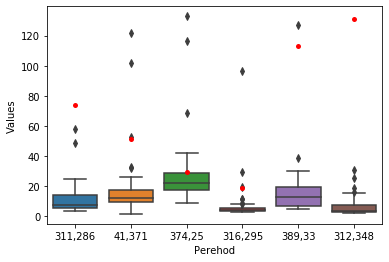

Сессия номер: 15 ;  736cca45634b541786a2049311bc717ecbd88d60


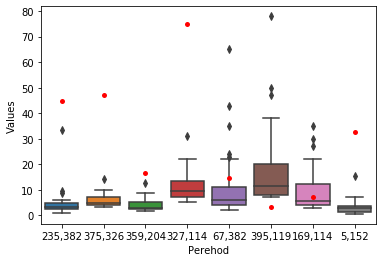

Сессия номер: 16 ;  7499c8e5703cd85d63a9e0d1957caa02c5bf476c


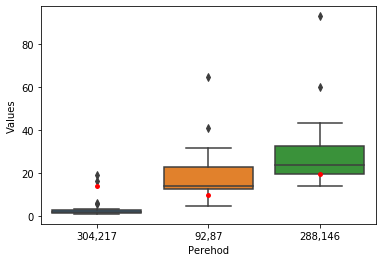

Сессия номер: 17 ;  a561ae764b1317ef485b3aea95ac8072bf632c44


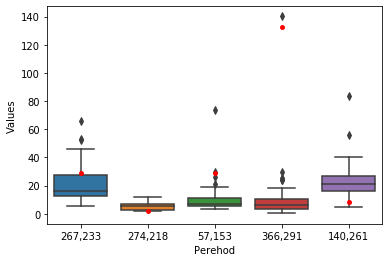

Сессия номер: 18 ;  1ea03c9dd3948548dc036ab43305955ca21199c6


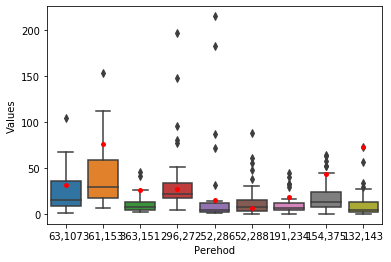

Сессия номер: 19 ;  bb4024c851d0022430375d6bbe33df9c2e053093


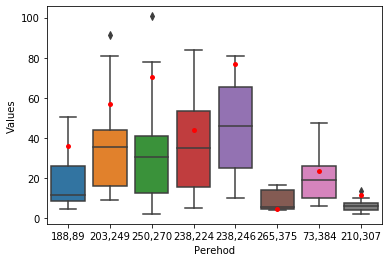

Сессия номер: 20 ;  c771a01b2f51bf310eaa80f1ff786832ee89c293


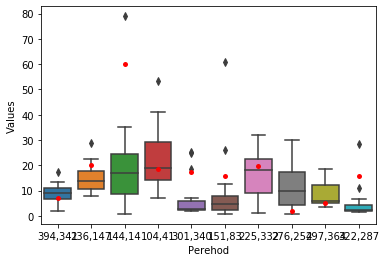

Сессия номер: 21 ;  2628e309dec27bb4ebf4ad5fd85bc9d5cfc4cbe5


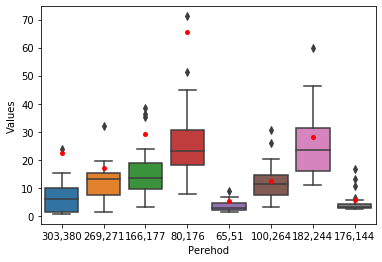

Сессия номер: 22 ;  e6ceb9ba46a00beb03df5ea79fb58eeb98e60f1f


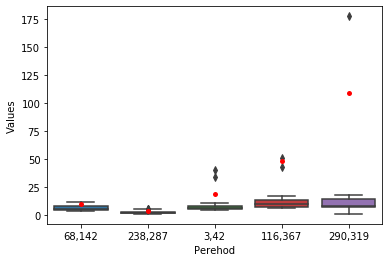

Сессия номер: 23 ;  c93042253c40323ad43a4f3e6212ddb097998bfe


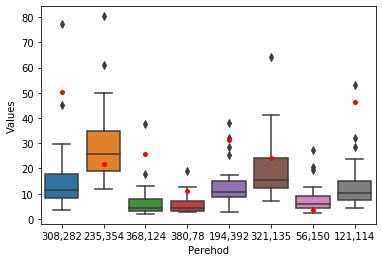

Сессия номер: 24 ;  73121a89c6113b175ee083b001a5175876d2b470


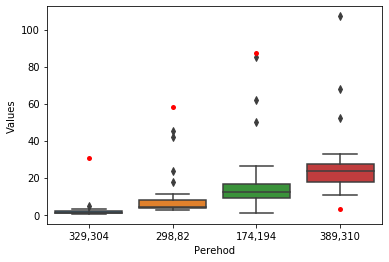

Сессия номер: 25 ;  ba7cf3b462401f7a89ea76d953276bc52f5622c0


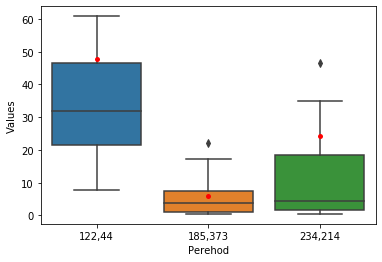

Сессия номер: 26 ;  2d22ac1d42e6187f09ee6c578df187a760123ccf


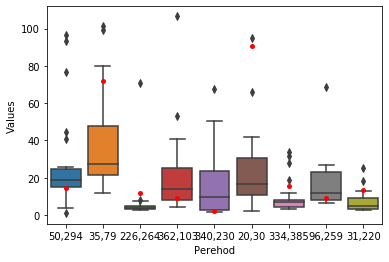

Сессия номер: 27 ;  b4a28ddbae199fa52875d0ae24fcc43da1506407


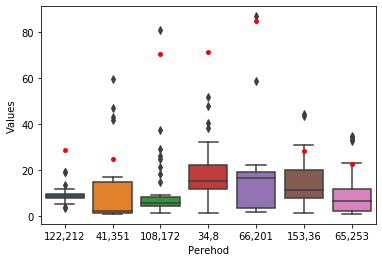

Сессия номер: 28 ;  73dc8f5748a14c821e64febc5e461a606f6bf7b1


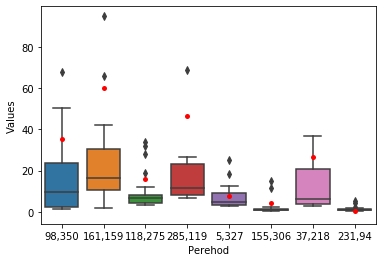

Сессия номер: 29 ;  fa755791d0509bb06ae715a2072de724815ed84d


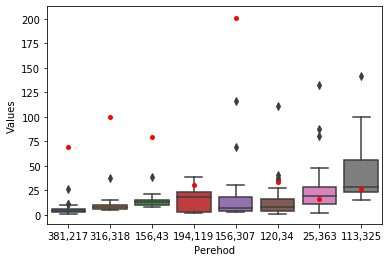

In [6]:
for session_iterator in range(len(file)-1506):     # Цикл по 30-ти сессиям
    data = []
    for x in [file[session_iterator][2]]:     # Цикл по истории переходов
        for l, t in enumerate(x):
            data.append([t , file[session_iterator][2][t]])

    research_data = []        
    for x in [file[session_iterator][1]]:     # Цикл по исследуемым сессиям
        for l, t in enumerate(x):
            research_data.append([t , file[session_iterator][1][t]])

    df = pd.DataFrame(data)                  # создание датафрейма истории
    df.columns=['Perehod','Values']

    dff = pd.DataFrame(research_data)        # создание датафрейма исследуемых значений
    dff.columns=['Perehod','Values']

    df.Perehod = df.Perehod.astype(str)
    df.explode('Values').reset_index(drop=True)

    print('Сессия номер:', session_iterator, "; ", file[session_iterator][0])
    aq = sns.boxplot(x="Perehod", y="Values", data=df.explode('Values').reset_index(drop=True))  
    aq = sns.swarmplot(x="Perehod", y="Values", data=dff, color="red")      # красная точка - рассматриваемая сессия
    
    plt.show()
    plt.clf()
    plt.close()

Мы получаем диаграммы по каждой сессии, в которых указаны переходы с точечным распределением задержек, на каждом столбце также указана **красная** точка, которая является значением из рассматриваемой сессии. Посмотрев на нее можно сделать вывод о том, насколько близко находится анализируемый переход к "плотности" основных переходов.

При просмотре датасета, я обнаружил, что в некоторых местах "ключи" из истории и исследуемой сессии иногда идут не по порядку, в котором далее записаны в истории, поэтому я сделал сначала сопоставление "ключей" переходов, чтобы решить проблему соответсвия рассматриваемого значения с **соответсвующей** ему историей.

Начнем с того, что соберем два датафрейма с историей и исследуемой выборкой, с двумя стобцами в каждом, 1-ый будет Perehod, 2-ой Values. Далее посмотрим на соответсвие ключей переходов и проверим на попадание в диапазон выбранного перехода в истории ранних переходов.

In [7]:
good_sessions = 0
normal_perehod = 0
for session_iterator in range(len(file)):     # Цикл по всем сессиям
    data = []
    for x in [file[session_iterator][2]]:     # Цикл по истории переходов
        for l, t in enumerate(x):
            data.append([t , file[session_iterator][2][t]])

    research_data = []        
    for x in [file[session_iterator][1]]:     # Цикл по исследуемым сессиям
        for l, t in enumerate(x):
            research_data.append([t , file[session_iterator][1][t]])

    df = pd.DataFrame(data)                  # создание датафрейма истории
    df.columns=['Perehod','Values']

    dff = pd.DataFrame(research_data)        # создание датафрейма исследуемых значений
    dff.columns=['Perehod','Values']

    try:                           # Поиск и сопоставление "ключа" исследуемой сессии с исторической сессией
        schetchik = 0 
        good_jump = 0
        for w in dff.iloc[:,0]:    # исследуемая сессия
            for q in df.iloc[:,0]: # история 
                if w == q:
                    indx = dff[dff['Perehod'] == w].index.tolist()
                    indx = int(indx[0]) 

                    print('Ключ такой - ', w, 'значение такое = ', dff.iloc[indx,1])  # получаем значение по ИНДЕКСУ,т.к. в датасете есть рассинхрон!

                    # берем значение по ключу в исслед сессии и проверяем его на попадание в диапазон в исторической сессии

                    if (dff.iloc[indx,1] >= min(df.iloc[indx,1]))&(dff.iloc[indx,1] <= max(df.iloc[indx,1])):
                        schetchik+=1
                        good_jump+=1
                        print("Внутри диапазона \n")
                    else:
                        schetchik+=1
                        print("Аномалия \n")

                else:
                    continue
        print('schetchik = ', schetchik)
        print('good_jump = ', good_jump)
        print(('Процент нормальных переходов = %.2f %%') % (100 * good_jump / schetchik))
        normal_perehod = int(100 * good_jump / schetchik)
        
        if normal_perehod >= 64:  # 19,8 % аномалий
            good_sessions+=1
        else: 
            continue
        print('Всего ХОРОШИХ сессий =', good_sessions, '\n')
        
    except:
        print("An error occurred")

Ключ такой -  323,188 значение такое =  7.334977046892243
Аномалия 

Ключ такой -  230,338 значение такое =  32.96108135150341
Внутри диапазона 

Ключ такой -  369,316 значение такое =  41.209561596990675
Внутри диапазона 

Ключ такой -  306,372 значение такое =  23.082700303788986
Внутри диапазона 

Ключ такой -  381,191 значение такое =  1.4749234075548538
Внутри диапазона 

schetchik =  5
good_jump =  4
Процент нормальных переходов = 80.00 %
Всего ХОРОШИХ сессий = 1 

Ключ такой -  218,58 значение такое =  47.01499175558943
Внутри диапазона 

Ключ такой -  132,206 значение такое =  10.431873162705458
Внутри диапазона 

Ключ такой -  106,219 значение такое =  11.89354234635774
Внутри диапазона 

Ключ такой -  208,8 значение такое =  27.587891157245956
Внутри диапазона 

Ключ такой -  30,314 значение такое =  19.200680280422098
Внутри диапазона 

Ключ такой -  303,37 значение такое =  51.2995413722438
Внутри диапазона 

Ключ такой -  19,100 значение такое =  46.03211849168697
Внутри д

Ключ такой -  188,89 значение такое =  35.80030683549725
Внутри диапазона 

Ключ такой -  203,249 значение такое =  57.035825892660746
Внутри диапазона 

Ключ такой -  250,270 значение такое =  70.5314891291606
Внутри диапазона 

Ключ такой -  238,224 значение такое =  43.991391291451826
Внутри диапазона 

Ключ такой -  238,246 значение такое =  76.70752667313238
Внутри диапазона 

Ключ такой -  265,375 значение такое =  4.552322651568362
Внутри диапазона 

Ключ такой -  73,384 значение такое =  23.348040627933603
Внутри диапазона 

Ключ такой -  210,307 значение такое =  11.629806019077538
Внутри диапазона 

schetchik =  8
good_jump =  8
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 17 

Ключ такой -  394,341 значение такое =  7.0995649699401495
Внутри диапазона 

Ключ такой -  236,147 значение такое =  20.117283717017774
Внутри диапазона 

Ключ такой -  144,14 значение такое =  59.89100128944436
Внутри диапазона 

Ключ такой -  104,41 значение такое =  18.69483934282

Ключ такой -  319,239 значение такое =  80.77302262604735
Внутри диапазона 

Ключ такой -  36,265 значение такое =  108.50381550576083
Внутри диапазона 

Ключ такой -  116,214 значение такое =  4.037855558927724
Внутри диапазона 

Ключ такой -  110,192 значение такое =  13.099110748450306
Внутри диапазона 

Ключ такой -  42,115 значение такое =  42.07714596957432
Внутри диапазона 

Ключ такой -  252,270 значение такое =  34.80626283390348
Внутри диапазона 

Ключ такой -  186,63 значение такое =  14.847149225083585
Внутри диапазона 

Ключ такой -  27,31 значение такое =  17.171885530194906
Внутри диапазона 

Ключ такой -  138,94 значение такое =  28.149254391903682
Внутри диапазона 

Ключ такой -  300,296 значение такое =  1.3656711244707005
Внутри диапазона 

schetchik =  10
good_jump =  10
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 30 

Ключ такой -  149,160 значение такое =  26.92799243507168
Внутри диапазона 

Ключ такой -  332,7 значение такое =  18.982939626726

Ключ такой -  328,345 значение такое =  10.60580618932466
Аномалия 

Ключ такой -  113,290 значение такое =  22.426501871163854
Внутри диапазона 

Ключ такой -  378,177 значение такое =  37.52021310647816
Аномалия 

Ключ такой -  300,124 значение такое =  43.74396031645594
Аномалия 

schetchik =  10
good_jump =  5
Процент нормальных переходов = 50.00 %
Ключ такой -  32,226 значение такое =  15.973863770827624
Внутри диапазона 

Ключ такой -  58,294 значение такое =  13.674760934044663
Внутри диапазона 

Ключ такой -  324,126 значение такое =  47.75897813306924
Внутри диапазона 

Ключ такой -  231,398 значение такое =  12.908905803589386
Внутри диапазона 

Ключ такой -  377,334 значение такое =  16.3990316078017
Внутри диапазона 

Ключ такой -  310,40 значение такое =  64.75668827571654
Внутри диапазона 

Ключ такой -  285,226 значение такое =  18.460689355698896
Внутри диапазона 

Ключ такой -  163,353 значение такое =  11.100557749768443
Внутри диапазона 

schetchik =  8
good_jump =  

Ключ такой -  35,79 значение такое =  14.920944731803786
Внутри диапазона 

schetchik =  6
good_jump =  5
Процент нормальных переходов = 83.33 %
Всего ХОРОШИХ сессий = 59 

Ключ такой -  6,233 значение такое =  18.34572044781086
Внутри диапазона 

Ключ такой -  257,181 значение такое =  8.28579693396166
Внутри диапазона 

Ключ такой -  147,52 значение такое =  36.85867134595034
Внутри диапазона 

Ключ такой -  27,86 значение такое =  78.19383591021449
Внутри диапазона 

Ключ такой -  155,357 значение такое =  7.390848742206998
Внутри диапазона 

Ключ такой -  324,82 значение такое =  28.323247849648812
Внутри диапазона 

Ключ такой -  24,94 значение такое =  49.59153769337725
Внутри диапазона 

schetchik =  7
good_jump =  7
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 60 

Ключ такой -  337,177 значение такое =  23.70162693300263
Внутри диапазона 

Ключ такой -  44,360 значение такое =  83.58468669257988
Внутри диапазона 

Ключ такой -  237,169 значение такое =  6.150

Ключ такой -  260,92 значение такое =  24.024595918853116
Внутри диапазона 

Ключ такой -  202,240 значение такое =  45.171789277107656
Внутри диапазона 

Ключ такой -  250,234 значение такое =  8.614335957832735
Внутри диапазона 

schetchik =  7
good_jump =  7
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 76 

Ключ такой -  329,334 значение такое =  36.590520000000005
Аномалия 

Ключ такой -  161,22 значение такое =  28.80909523809524
Внутри диапазона 

Ключ такой -  226,100 значение такое =  25.793439999999997
Внутри диапазона 

Ключ такой -  98,218 значение такое =  28.917333333333335
Аномалия 

Ключ такой -  176,323 значение такое =  7.843863636363637
Внутри диапазона 

Ключ такой -  258,186 значение такое =  21.910040000000002
Внутри диапазона 

Ключ такой -  318,162 значение такое =  50.88288369629471
Аномалия 

Ключ такой -  11,206 значение такое =  4.56826068418822
Внутри диапазона 

Ключ такой -  8,393 значение такое =  19.99907750058358
Аномалия 

schetchik =

Ключ такой -  372,389 значение такое =  37.26392704583981
Внутри диапазона 

Ключ такой -  336,100 значение такое =  33.64488487885356
Внутри диапазона 

Ключ такой -  230,83 значение такое =  122.30524560751752
Аномалия 

schetchik =  9
good_jump =  5
Процент нормальных переходов = 55.56 %
Ключ такой -  208,388 значение такое =  30.76973073651644
Внутри диапазона 

Ключ такой -  101,100 значение такое =  14.608973441087826
Внутри диапазона 

Ключ такой -  92,136 значение такое =  10.24188343885163
Внутри диапазона 

Ключ такой -  17,97 значение такое =  25.075709702463126
Внутри диапазона 

Ключ такой -  261,228 значение такое =  37.12813301119643
Внутри диапазона 

Ключ такой -  50,345 значение такое =  15.377846883400126
Внутри диапазона 

Ключ такой -  193,280 значение такое =  45.15075665373588
Внутри диапазона 

schetchik =  7
good_jump =  7
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 100 

Ключ такой -  335,69 значение такое =  1.0047627660810612
Аномалия 

Кл

Внутри диапазона 

Ключ такой -  66,20 значение такое =  85.20090680796673
Внутри диапазона 

Ключ такой -  58,47 значение такое =  78.21227518486542
Внутри диапазона 

Ключ такой -  6,124 значение такое =  11.305948439034136
Внутри диапазона 

Ключ такой -  90,51 значение такое =  8.174624516432207
Внутри диапазона 

schetchik =  5
good_jump =  5
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 118 

Ключ такой -  147,15 значение такое =  18.469187232603545
Внутри диапазона 

Ключ такой -  310,31 значение такое =  61.303657593156515
Внутри диапазона 

Ключ такой -  296,376 значение такое =  37.746733171680596
Внутри диапазона 

Ключ такой -  286,243 значение такое =  31.32542581397423
Внутри диапазона 

Ключ такой -  35,70 значение такое =  7.0285572881020375
Внутри диапазона 

schetchik =  5
good_jump =  5
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 119 

Ключ такой -  133,202 значение такое =  102.10579158009308
Аномалия 

Ключ такой -  263,27 значен

Ключ такой -  254,144 значение такое =  178.33970588235297
Аномалия 

Ключ такой -  274,55 значение такое =  32.88377777777778
Аномалия 

Ключ такой -  298,20 значение такое =  117.46021739130434
Аномалия 

Ключ такой -  382,341 значение такое =  86.08958823529413
Внутри диапазона 

Ключ такой -  22,308 значение такое =  130.3964705882353
Аномалия 

Ключ такой -  113,271 значение такое =  23.93879110901046
Внутри диапазона 

Ключ такой -  380,316 значение такое =  8.409280712698676
Внутри диапазона 

schetchik =  7
good_jump =  3
Процент нормальных переходов = 42.86 %
Ключ такой -  210,17 значение такое =  19.657263727995666
Внутри диапазона 

Ключ такой -  179,138 значение такое =  31.293155728766894
Внутри диапазона 

Ключ такой -  7,155 значение такое =  43.60909579745766
Внутри диапазона 

Ключ такой -  45,26 значение такое =  20.954659848335368
Внутри диапазона 

Ключ такой -  334,48 значение такое =  107.6124121082253
Внутри диапазона 

Ключ такой -  44,135 значение такое =  103.

Ключ такой -  169,379 значение такое =  6.167856691248373
Внутри диапазона 

Ключ такой -  27,146 значение такое =  16.37988688341997
Внутри диапазона 

Ключ такой -  113,223 значение такое =  25.92501100981923
Внутри диапазона 

Ключ такой -  156,50 значение такое =  15.579102423836915
Внутри диапазона 

schetchik =  4
good_jump =  4
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 149 

Ключ такой -  132,179 значение такое =  21.65768681056635
Внутри диапазона 

Ключ такой -  131,9 значение такое =  19.492292381007353
Внутри диапазона 

Ключ такой -  242,211 значение такое =  103.96872287543545
Внутри диапазона 

Ключ такой -  142,4 значение такое =  0.6541415350330723
Внутри диапазона 

Ключ такой -  83,381 значение такое =  90.90746232779694
Внутри диапазона 

Ключ такой -  289,377 значение такое =  16.458267307202874
Внутри диапазона 

Ключ такой -  394,357 значение такое =  4.19292991558911
Внутри диапазона 

Ключ такой -  186,197 значение такое =  19.43377997906028

Внутри диапазона 

Ключ такой -  375,187 значение такое =  11.554646421700738
Аномалия 

schetchik =  9
good_jump =  5
Процент нормальных переходов = 55.56 %
Ключ такой -  357,386 значение такое =  63.55592
Аномалия 

Ключ такой -  270,150 значение такое =  81.25247368421051
Аномалия 

Ключ такой -  308,311 значение такое =  76.11658823529412
Аномалия 

Ключ такой -  194,307 значение такое =  28.637596153846157
Аномалия 

Ключ такой -  386,342 значение такое =  39.67844827586207
Аномалия 

Ключ такой -  138,222 значение такое =  16.463928571428568
Внутри диапазона 

Ключ такой -  161,169 значение такое =  12.351123750115436
Внутри диапазона 

Ключ такой -  68,302 значение такое =  58.86302689321915
Аномалия 

Ключ такой -  399,82 значение такое =  51.26297492492716
Аномалия 

Ключ такой -  63,32 значение такое =  13.536178926817987
Внутри диапазона 

schetchik =  10
good_jump =  3
Процент нормальных переходов = 30.00 %
Ключ такой -  224,369 значение такое =  13.459920000000002
Внутри д

Ключ такой -  303,294 значение такое =  125.92686538461538
Аномалия 

Ключ такой -  10,90 значение такое =  104.5172969106478
Аномалия 

schetchik =  4
good_jump =  1
Процент нормальных переходов = 25.00 %
Ключ такой -  351,181 значение такое =  39.9381875
Аномалия 

Ключ такой -  249,244 значение такое =  118.73790384615386
Аномалия 

Ключ такой -  321,343 значение такое =  40.25531578947369
Аномалия 

Ключ такой -  67,29 значение такое =  5.841383073197321
Внутри диапазона 

schetchik =  4
good_jump =  1
Процент нормальных переходов = 25.00 %
Ключ такой -  131,222 значение такое =  38.79265053039378
Внутри диапазона 

Ключ такой -  217,43 значение такое =  54.08256321022191
Внутри диапазона 

Ключ такой -  170,321 значение такое =  63.792182752035075
Внутри диапазона 

Ключ такой -  190,355 значение такое =  4.918878844762302
Внутри диапазона 

Ключ такой -  23,338 значение такое =  50.003807135128866
Внутри диапазона 

Ключ такой -  388,137 значение такое =  7.451088928851152
Внутри

Ключ такой -  372,42 значение такое =  1.7998489345389557
Внутри диапазона 

Ключ такой -  399,74 значение такое =  10.940822532644079
Внутри диапазона 

Ключ такой -  294,11 значение такое =  11.14296858288665
Внутри диапазона 

schetchik =  7
good_jump =  6
Процент нормальных переходов = 85.71 %
Всего ХОРОШИХ сессий = 193 

Ключ такой -  263,166 значение такое =  91.42929213883977
Внутри диапазона 

Ключ такой -  278,69 значение такое =  26.206744940650882
Внутри диапазона 

Ключ такой -  173,381 значение такое =  24.24699452652401
Внутри диапазона 

Ключ такой -  348,279 значение такое =  75.76697496660609
Внутри диапазона 

Ключ такой -  266,176 значение такое =  12.15493777151027
Внутри диапазона 

Ключ такой -  382,1 значение такое =  42.141331728397454
Внутри диапазона 

schetchik =  6
good_jump =  6
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 194 

Ключ такой -  85,21 значение такое =  110.43181831331711
Внутри диапазона 

Ключ такой -  191,56 значение такое 

Ключ такой -  141,129 значение такое =  13.534521739130433
Внутри диапазона 

Ключ такой -  70,304 значение такое =  26.96278947368421
Внутри диапазона 

Ключ такой -  189,110 значение такое =  44.32160869565217
Аномалия 

Ключ такой -  32,372 значение такое =  13.302276228451733
Внутри диапазона 

Ключ такой -  16,231 значение такое =  54.50186228393654
Внутри диапазона 

schetchik =  7
good_jump =  5
Процент нормальных переходов = 71.43 %
Всего ХОРОШИХ сессий = 211 

Ключ такой -  283,399 значение такое =  6.911310989157976
Внутри диапазона 

Ключ такой -  12,372 значение такое =  15.758022051353406
Аномалия 

Ключ такой -  185,313 значение такое =  21.04972074093744
Внутри диапазона 

Ключ такой -  341,251 значение такое =  14.292586659305758
Внутри диапазона 

Ключ такой -  325,341 значение такое =  33.87088172514122
Внутри диапазона 

Ключ такой -  396,212 значение такое =  12.029198150545277
Внутри диапазона 

Ключ такой -  226,54 значение такое =  14.876169076425327
Внутри диапа

Внутри диапазона 

Ключ такой -  147,352 значение такое =  115.40720298910412
Внутри диапазона 

Ключ такой -  204,164 значение такое =  6.76422748484994
Внутри диапазона 

Ключ такой -  345,201 значение такое =  9.703042537657906
Внутри диапазона 

Ключ такой -  72,325 значение такое =  18.82833350026639
Внутри диапазона 

Ключ такой -  100,353 значение такое =  4.060780752315901
Внутри диапазона 

Ключ такой -  336,78 значение такое =  45.4205496230265
Внутри диапазона 

schetchik =  9
good_jump =  9
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 226 

Ключ такой -  46,8 значение такое =  12.659321120365234
Внутри диапазона 

Ключ такой -  179,326 значение такое =  69.76379313220183
Внутри диапазона 

Ключ такой -  20,398 значение такое =  3.8825830920609965
Внутри диапазона 

schetchik =  3
good_jump =  3
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 227 

Ключ такой -  358,281 значение такое =  244.89570306198223
Внутри диапазона 

Ключ такой -  100

Ключ такой -  353,30 значение такое =  21.703351851851853
Внутри диапазона 

Ключ такой -  232,349 значение такое =  119.9540909090909
Аномалия 

Ключ такой -  279,66 значение такое =  100.05736
Аномалия 

Ключ такой -  209,24 значение такое =  25.407352941176466
Аномалия 

Ключ такой -  186,280 значение такое =  13.936333333333334
Внутри диапазона 

Ключ такой -  169,380 значение такое =  97.26872058823531
Аномалия 

Ключ такой -  202,399 значение такое =  38.416940396300895
Аномалия 

Ключ такой -  99,284 значение такое =  7.585011982395906
Аномалия 

Ключ такой -  326,20 значение такое =  16.21050857902724
Аномалия 

schetchik =  9
good_jump =  2
Процент нормальных переходов = 22.22 %
Ключ такой -  328,343 значение такое =  26.982523280738413
Внутри диапазона 

Ключ такой -  6,54 значение такое =  25.679014240877947
Внутри диапазона 

Ключ такой -  51,6 значение такое =  16.012197121540684
Внутри диапазона 

Ключ такой -  304,227 значение такое =  40.618132162396215
Внутри диапазона

Ключ такой -  75,265 значение такое =  8.045207979961015
Внутри диапазона 

schetchik =  7
good_jump =  6
Процент нормальных переходов = 85.71 %
Всего ХОРОШИХ сессий = 251 

Ключ такой -  312,128 значение такое =  43.13750000640772
Внутри диапазона 

Ключ такой -  39,374 значение такое =  8.86165939878718
Внутри диапазона 

Ключ такой -  296,310 значение такое =  34.653169715566996
Внутри диапазона 

Ключ такой -  95,155 значение такое =  17.609420321906818
Внутри диапазона 

Ключ такой -  330,119 значение такое =  45.203428683121835
Внутри диапазона 

Ключ такой -  86,332 значение такое =  21.18272768725695
Внутри диапазона 

schetchik =  6
good_jump =  6
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 252 

Ключ такой -  297,210 значение такое =  14.711602544323934
Внутри диапазона 

Ключ такой -  256,199 значение такое =  13.219803924651451
Внутри диапазона 

Ключ такой -  378,300 значение такое =  84.80898196508144
Внутри диапазона 

schetchik =  3
good_jump =  3
Про

Ключ такой -  169,46 значение такое =  20.495078688664034
Внутри диапазона 

Ключ такой -  380,97 значение такое =  16.919643899684207
Внутри диапазона 

Ключ такой -  229,33 значение такое =  37.44523234878277
Внутри диапазона 

Ключ такой -  300,79 значение такое =  14.849384570575328
Внутри диапазона 

Ключ такой -  269,182 значение такое =  7.014677789335802
Внутри диапазона 

schetchik =  10
good_jump =  10
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 269 

Ключ такой -  94,295 значение такое =  39.04785429048439
Внутри диапазона 

Ключ такой -  376,230 значение такое =  0.28167977213033657
Аномалия 

Ключ такой -  322,210 значение такое =  10.667590486244036
Внутри диапазона 

Ключ такой -  54,269 значение такое =  24.672833405722862
Внутри диапазона 

Ключ такой -  398,16 значение такое =  8.714123354094234
Внутри диапазона 

Ключ такой -  135,25 значение такое =  2.5210059297843865
Внутри диапазона 

Ключ такой -  179,385 значение такое =  45.3271884172729
Вну

Ключ такой -  377,193 значение такое =  23.388343600729513
Внутри диапазона 

Ключ такой -  2,165 значение такое =  26.30821620422715
Внутри диапазона 

Ключ такой -  57,114 значение такое =  8.290666547591744
Внутри диапазона 

schetchik =  8
good_jump =  8
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 285 

Ключ такой -  272,371 значение такое =  15.723403846153847
Внутри диапазона 

Ключ такой -  29,111 значение такое =  18.01441379310345
Внутри диапазона 

Ключ такой -  152,296 значение такое =  14.9061500554576
Внутри диапазона 

schetchik =  3
good_jump =  3
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 286 

Ключ такой -  184,32 значение такое =  27.602687500000002
Внутри диапазона 

Ключ такой -  270,242 значение такое =  47.447966666666666
Внутри диапазона 

Ключ такой -  209,47 значение такое =  14.054041666666667
Внутри диапазона 

Ключ такой -  178,263 значение такое =  28.516217200993207
Аномалия 

Ключ такой -  143,326 значение такое =  2

Ключ такой -  30,368 значение такое =  16.468173389786255
Внутри диапазона 

Ключ такой -  358,61 значение такое =  13.441311168387791
Внутри диапазона 

Ключ такой -  107,129 значение такое =  54.7674934808581
Внутри диапазона 

Ключ такой -  227,223 значение такое =  31.956326614250116
Внутри диапазона 

schetchik =  4
good_jump =  4
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 303 

Ключ такой -  370,387 значение такое =  46.52695328687219
Внутри диапазона 

Ключ такой -  315,354 значение такое =  26.398382508751357
Внутри диапазона 

Ключ такой -  318,212 значение такое =  13.07867374858324
Внутри диапазона 

Ключ такой -  127,112 значение такое =  18.538551792047034
Внутри диапазона 

Ключ такой -  365,105 значение такое =  16.568924333901773
Внутри диапазона 

Ключ такой -  308,64 значение такое =  45.89776317128086
Внутри диапазона 

schetchik =  6
good_jump =  6
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 304 

Ключ такой -  107,276 значение

Ключ такой -  117,128 значение такое =  8.768233519940628
Внутри диапазона 

schetchik =  8
good_jump =  8
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 317 

Ключ такой -  314,325 значение такое =  26.511796682904503
Внутри диапазона 

Ключ такой -  376,376 значение такое =  38.63326372630348
Внутри диапазона 

Ключ такой -  98,189 значение такое =  29.285543618348658
Внутри диапазона 

Ключ такой -  230,202 значение такое =  4.097357996879974
Внутри диапазона 

Ключ такой -  158,241 значение такое =  14.743729392699251
Внутри диапазона 

Ключ такой -  193,16 значение такое =  15.418675090469963
Внутри диапазона 

Ключ такой -  144,29 значение такое =  17.006439720527705
Внутри диапазона 

Ключ такой -  140,207 значение такое =  22.727318904278754
Внутри диапазона 

schetchik =  8
good_jump =  8
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 318 

Ключ такой -  397,86 значение такое =  52.95430580146511
Внутри диапазона 

Ключ такой -  310,331 значение

Ключ такой -  185,309 значение такое =  16.259807389027053
Внутри диапазона 

Ключ такой -  387,77 значение такое =  8.604605227721445
Внутри диапазона 

Ключ такой -  358,2 значение такое =  13.926942424876682
Внутри диапазона 

schetchik =  4
good_jump =  4
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 344 

Ключ такой -  33,372 значение такое =  13.819793547076307
Внутри диапазона 

Ключ такой -  69,59 значение такое =  248.29488323832217
Внутри диапазона 

Ключ такой -  18,375 значение такое =  11.783724297109652
Внутри диапазона 

Ключ такой -  174,188 значение такое =  18.753437991120354
Внутри диапазона 

Ключ такой -  337,313 значение такое =  4.800795767792428
Внутри диапазона 

schetchik =  5
good_jump =  5
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 345 

Ключ такой -  208,372 значение такое =  98.63706351037683
Аномалия 

Ключ такой -  304,126 значение такое =  71.19354325508894
Внутри диапазона 

Ключ такой -  245,141 значение такое =  5

Ключ такой -  203,41 значение такое =  171.83630028323176
Внутри диапазона 

Ключ такой -  213,221 значение такое =  55.4410531825511
Внутри диапазона 

Ключ такой -  306,152 значение такое =  113.3771062724211
Внутри диапазона 

schetchik =  7
good_jump =  6
Процент нормальных переходов = 85.71 %
Всего ХОРОШИХ сессий = 365 

Ключ такой -  58,268 значение такое =  17.116371131547073
Внутри диапазона 

Ключ такой -  352,211 значение такое =  22.844498355779162
Внутри диапазона 

Ключ такой -  158,391 значение такое =  30.307284170751846
Внутри диапазона 

Ключ такой -  149,24 значение такое =  31.388541006325664
Аномалия 

Ключ такой -  113,366 значение такое =  47.964370191181686
Внутри диапазона 

Ключ такой -  58,159 значение такое =  64.12522867828595
Внутри диапазона 

Ключ такой -  75,265 значение такое =  8.045207979961015
Внутри диапазона 

schetchik =  7
good_jump =  6
Процент нормальных переходов = 85.71 %
Всего ХОРОШИХ сессий = 366 

Ключ такой -  227,304 значение такое =  37

Ключ такой -  377,60 значение такое =  37.140454545454546
Аномалия 

Ключ такой -  36,44 значение такое =  76.89473684210526
Аномалия 

Ключ такой -  118,344 значение такое =  62.260408359762756
Аномалия 

Ключ такой -  262,105 значение такое =  22.635644341079498
Внутри диапазона 

schetchik =  5
good_jump =  2
Процент нормальных переходов = 40.00 %
Ключ такой -  19,351 значение такое =  52.355091930555226
Внутри диапазона 

Ключ такой -  221,352 значение такое =  3.9354830986312868
Внутри диапазона 

Ключ такой -  47,297 значение такое =  23.139410606625905
Внутри диапазона 

Ключ такой -  281,37 значение такое =  53.84401823778415
Внутри диапазона 

Ключ такой -  330,117 значение такое =  39.25577252751658
Внутри диапазона 

Ключ такой -  18,253 значение такое =  6.326812225823508
Внутри диапазона 

Ключ такой -  382,200 значение такое =  110.04941602156168
Внутри диапазона 

Ключ такой -  163,279 значение такое =  6.655129182431185
Внутри диапазона 

Ключ такой -  313,131 значение 

Ключ такой -  32,300 значение такое =  32.45020921593393
Внутри диапазона 

schetchik =  6
good_jump =  5
Процент нормальных переходов = 83.33 %
Всего ХОРОШИХ сессий = 395 

Ключ такой -  350,197 значение такое =  21.920722813491334
Внутри диапазона 

Ключ такой -  296,160 значение такое =  137.59998654215627
Внутри диапазона 

Ключ такой -  378,150 значение такое =  82.48786595579352
Внутри диапазона 

Ключ такой -  200,19 значение такое =  10.32552459897322
Внутри диапазона 

Ключ такой -  247,188 значение такое =  99.9394411769102
Внутри диапазона 

schetchik =  5
good_jump =  5
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 396 

Ключ такой -  99,246 значение такое =  7.892650587004033
Внутри диапазона 

Ключ такой -  102,167 значение такое =  64.01859728444903
Внутри диапазона 

Ключ такой -  389,63 значение такое =  19.116022746231863
Внутри диапазона 

Ключ такой -  366,126 значение такое =  3.939635360371223
Внутри диапазона 

Ключ такой -  116,191 значение тако

Ключ такой -  329,93 значение такое =  35.08155555555556
Внутри диапазона 

Ключ такой -  34,138 значение такое =  9.64137706399687
Внутри диапазона 

Ключ такой -  223,193 значение такое =  5.796428620413353
Внутри диапазона 

schetchik =  7
good_jump =  5
Процент нормальных переходов = 71.43 %
Всего ХОРОШИХ сессий = 409 

Ключ такой -  38,229 значение такое =  77.40935127832863
Внутри диапазона 

Ключ такой -  297,85 значение такое =  75.56281424215958
Внутри диапазона 

Ключ такой -  258,323 значение такое =  28.67602721094027
Внутри диапазона 

Ключ такой -  141,137 значение такое =  2.9726782323627985
Внутри диапазона 

Ключ такой -  159,235 значение такое =  8.867331074182957
Внутри диапазона 

Ключ такой -  248,244 значение такое =  0.5116472536866885
Аномалия 

Ключ такой -  266,326 значение такое =  19.244679987734347
Внутри диапазона 

schetchik =  7
good_jump =  6
Процент нормальных переходов = 85.71 %
Всего ХОРОШИХ сессий = 410 

Ключ такой -  89,219 значение такое =  19.77

Ключ такой -  9,381 значение такое =  15.532113300551273
Внутри диапазона 

Ключ такой -  268,388 значение такое =  5.365087012224456
Внутри диапазона 

Ключ такой -  144,34 значение такое =  22.68693926848757
Внутри диапазона 

Ключ такой -  152,213 значение такое =  5.359262831913245
Внутри диапазона 

schetchik =  9
good_jump =  9
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 432 

Ключ такой -  233,307 значение такое =  73.29159372472152
Внутри диапазона 

Ключ такой -  308,394 значение такое =  4.63134006363736
Внутри диапазона 

Ключ такой -  275,82 значение такое =  28.318271213674976
Внутри диапазона 

schetchik =  3
good_jump =  3
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 433 

Ключ такой -  171,328 значение такое =  2.2692069128098087
Внутри диапазона 

Ключ такой -  284,227 значение такое =  9.903838773716164
Внутри диапазона 

Ключ такой -  169,72 значение такое =  27.460883344506335
Внутри диапазона 

Ключ такой -  2,336 значение такое

Ключ такой -  370,387 значение такое =  46.52695328687219
Внутри диапазона 

Ключ такой -  315,354 значение такое =  26.398382508751357
Внутри диапазона 

Ключ такой -  318,212 значение такое =  13.07867374858324
Внутри диапазона 

Ключ такой -  127,112 значение такое =  18.538551792047034
Внутри диапазона 

Ключ такой -  365,105 значение такое =  16.568924333901773
Внутри диапазона 

Ключ такой -  308,64 значение такое =  45.89776317128086
Внутри диапазона 

schetchik =  6
good_jump =  6
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 449 

Ключ такой -  191,13 значение такое =  92.43343750000003
Аномалия 

Ключ такой -  179,49 значение такое =  25.20467857142857
Внутри диапазона 

Ключ такой -  126,285 значение такое =  94.47420454545454
Аномалия 

Ключ такой -  370,238 значение такое =  7.665867253567013
Внутри диапазона 

schetchik =  4
good_jump =  2
Процент нормальных переходов = 50.00 %
Ключ такой -  328,21 значение такое =  49.348090120059766
Внутри диапазона 

К

Ключ такой -  223,193 значение такое =  5.796428620413353
Внутри диапазона 

schetchik =  7
good_jump =  5
Процент нормальных переходов = 71.43 %
Всего ХОРОШИХ сессий = 462 

Ключ такой -  291,104 значение такое =  131.75714285714287
Аномалия 

Ключ такой -  278,260 значение такое =  130.38591666666665
Аномалия 

Ключ такой -  185,199 значение такое =  20.669299012131674
Внутри диапазона 

schetchik =  3
good_jump =  1
Процент нормальных переходов = 33.33 %
Ключ такой -  200,129 значение такое =  146.38114067008007
Внутри диапазона 

Ключ такой -  180,32 значение такое =  20.924223673836163
Внутри диапазона 

Ключ такой -  199,265 значение такое =  57.26803387474929
Внутри диапазона 

Ключ такой -  46,301 значение такое =  49.60137713632547
Внутри диапазона 

Ключ такой -  397,246 значение такое =  56.469432320234134
Внутри диапазона 

Ключ такой -  9,301 значение такое =  13.58993589805122
Внутри диапазона 

Ключ такой -  78,377 значение такое =  9.170411135755788
Внутри диапазона 

s

Ключ такой -  284,193 значение такое =  82.12295238095238
Аномалия 

Ключ такой -  264,317 значение такое =  36.63134210526316
Внутри диапазона 

Ключ такой -  341,342 значение такое =  28.72438095238095
Внутри диапазона 

Ключ такой -  28,258 значение такое =  3.3767266419073585
Внутри диапазона 

schetchik =  4
good_jump =  3
Процент нормальных переходов = 75.00 %
Всего ХОРОШИХ сессий = 478 

Ключ такой -  210,17 значение такое =  19.657263727995666
Внутри диапазона 

Ключ такой -  179,138 значение такое =  31.293155728766894
Внутри диапазона 

Ключ такой -  7,155 значение такое =  43.60909579745766
Внутри диапазона 

Ключ такой -  45,26 значение такое =  20.954659848335368
Внутри диапазона 

Ключ такой -  334,48 значение такое =  107.6124121082253
Внутри диапазона 

Ключ такой -  44,135 значение такое =  103.61539760353891
Внутри диапазона 

schetchik =  6
good_jump =  6
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 479 

Ключ такой -  73,136 значение такое =  30.77

Ключ такой -  13,121 значение такое =  43.851810592492214
Внутри диапазона 

schetchik =  6
good_jump =  6
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 495 

Ключ такой -  355,111 значение такое =  21.83554411764706
Аномалия 

Ключ такой -  151,66 значение такое =  87.39276470588234
Аномалия 

Ключ такой -  191,71 значение такое =  87.06948076923076
Аномалия 

Ключ такой -  381,308 значение такое =  70.87020689655174
Аномалия 

Ключ такой -  130,40 значение такое =  10.379
Внутри диапазона 

Ключ такой -  107,89 значение такое =  17.37564837831634
Аномалия 

Ключ такой -  218,313 значение такое =  10.853418226568827
Внутри диапазона 

Ключ такой -  122,324 значение такое =  17.318967066375997
Аномалия 

schetchik =  8
good_jump =  2
Процент нормальных переходов = 25.00 %
Ключ такой -  80,374 значение такое =  7.481575361968824
Внутри диапазона 

Ключ такой -  47,52 значение такое =  72.99209314381876
Внутри диапазона 

Ключ такой -  397,242 значение такое =  24.807617

Ключ такой -  61,384 значение такое =  54.590929309545295
Внутри диапазона 

schetchik =  3
good_jump =  1
Процент нормальных переходов = 33.33 %
Ключ такой -  1,356 значение такое =  19.44213782894745
Внутри диапазона 

Ключ такой -  399,6 значение такое =  62.85919677988347
Внутри диапазона 

Ключ такой -  274,47 значение такое =  36.139058763899065
Внутри диапазона 

Ключ такой -  265,19 значение такое =  29.14317205160781
Внутри диапазона 

Ключ такой -  34,195 значение такое =  9.76708969699218
Внутри диапазона 

Ключ такой -  277,150 значение такое =  7.388138135960246
Внутри диапазона 

schetchik =  6
good_jump =  6
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 512 

Ключ такой -  72,259 значение такое =  73.43892592592591
Аномалия 

Ключ такой -  259,341 значение такое =  74.65168
Аномалия 

Ключ такой -  171,190 значение такое =  18.421
Аномалия 

Ключ такой -  345,16 значение такое =  65.24133870967742
Внутри диапазона 

Ключ такой -  51,32 значение такое =  

Ключ такой -  243,240 значение такое =  19.110255403342848
Внутри диапазона 

Ключ такой -  392,383 значение такое =  100.10606249303719
Внутри диапазона 

schetchik =  8
good_jump =  8
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 532 

Ключ такой -  272,371 значение такое =  15.723403846153847
Внутри диапазона 

Ключ такой -  29,111 значение такое =  18.01441379310345
Внутри диапазона 

Ключ такой -  152,296 значение такое =  14.9061500554576
Внутри диапазона 

schetchik =  3
good_jump =  3
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 533 

Ключ такой -  169,350 значение такое =  5.754799985182122
Внутри диапазона 

Ключ такой -  358,310 значение такое =  22.595313280209744
Внутри диапазона 

Ключ такой -  30,33 значение такое =  87.59892855902031
Внутри диапазона 

schetchik =  3
good_jump =  3
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 534 

Ключ такой -  309,225 значение такое =  83.64097142857145
Аномалия 

Ключ такой -  391,


Ключ такой -  205,20 значение такое =  78.02436538461536
Аномалия 

Ключ такой -  22,361 значение такое =  37.815207259176425
Внутри диапазона 

Ключ такой -  140,244 значение такое =  10.904303385395325
Внутри диапазона 

schetchik =  7
good_jump =  4
Процент нормальных переходов = 57.14 %
Ключ такой -  151,5 значение такое =  40.998549999999994
Аномалия 

Ключ такой -  178,219 значение такое =  19.865250000000003
Внутри диапазона 

Ключ такой -  310,96 значение такое =  7.23049331229708
Внутри диапазона 

schetchik =  3
good_jump =  2
Процент нормальных переходов = 66.67 %
Всего ХОРОШИХ сессий = 552 

Ключ такой -  146,365 значение такое =  44.942494058492834
Внутри диапазона 

Ключ такой -  93,343 значение такое =  7.69468859111741
Внутри диапазона 

Ключ такой -  177,357 значение такое =  6.541297284467253
Внутри диапазона 

Ключ такой -  97,276 значение такое =  26.517889121221852
Аномалия 

Ключ такой -  174,184 значение такое =  3.975081167619212
Внутри диапазона 

schetchik = 

Ключ такой -  55,98 значение такое =  140.28590837866585
Внутри диапазона 

Ключ такой -  123,215 значение такое =  74.12261416297547
Внутри диапазона 

schetchik =  8
good_jump =  8
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 561 

Ключ такой -  293,263 значение такое =  67.98834615384615
Аномалия 

Ключ такой -  340,45 значение такое =  14.357285714285716
Внутри диапазона 

Ключ такой -  356,184 значение такое =  50.673500873562126
Аномалия 

schetchik =  3
good_jump =  1
Процент нормальных переходов = 33.33 %
Ключ такой -  357,209 значение такое =  34.745106625769886
Внутри диапазона 

Ключ такой -  246,267 значение такое =  57.03154153878281
Внутри диапазона 

Ключ такой -  275,157 значение такое =  59.68136973763727
Внутри диапазона 

Ключ такой -  113,374 значение такое =  58.09320864737757
Внутри диапазона 

Ключ такой -  199,122 значение такое =  9.250138146119255
Внутри диапазона 

Ключ такой -  235,227 значение такое =  47.45632317611161
Внутри диапазона 



Ключ такой -  43,232 значение такое =  42.32833901668132
Аномалия 

Ключ такой -  278,82 значение такое =  14.746229476682325
Внутри диапазона 

Ключ такой -  325,327 значение такое =  18.492441376982683
Внутри диапазона 

Ключ такой -  347,284 значение такое =  6.584377652415374
Внутри диапазона 

schetchik =  8
good_jump =  7
Процент нормальных переходов = 87.50 %
Всего ХОРОШИХ сессий = 575 

Ключ такой -  228,171 значение такое =  23.4998
Внутри диапазона 

Ключ такой -  243,14 значение такое =  92.56752
Аномалия 

Ключ такой -  274,283 значение такое =  46.73908064516129
Аномалия 

Ключ такой -  210,43 значение такое =  88.63668181818181
Внутри диапазона 

Ключ такой -  252,35 значение такое =  29.520259881269684
Внутри диапазона 

Ключ такой -  255,27 значение такое =  22.467736984033802
Аномалия 

schetchik =  6
good_jump =  3
Процент нормальных переходов = 50.00 %
Ключ такой -  325,244 значение такое =  35.144812878871775
Внутри диапазона 

Ключ такой -  63,287 значение такое = 

Ключ такой -  24,271 значение такое =  6.38131768956249
Внутри диапазона 

Ключ такой -  324,91 значение такое =  8.762204636661755
Внутри диапазона 

schetchik =  5
good_jump =  4
Процент нормальных переходов = 80.00 %
Всего ХОРОШИХ сессий = 588 

Ключ такой -  259,49 значение такое =  261.1666
Аномалия 

Ключ такой -  280,394 значение такое =  18.969739130434778
Внутри диапазона 

Ключ такой -  351,193 значение такое =  87.66290476190477
Внутри диапазона 

Ключ такой -  320,336 значение такое =  308.5520588235294
Аномалия 

Ключ такой -  87,384 значение такое =  34.129383203736424
Аномалия 

Ключ такой -  363,84 значение такое =  79.50924672714349
Аномалия 

schetchik =  6
good_jump =  2
Процент нормальных переходов = 33.33 %
Ключ такой -  329,183 значение такое =  11.958113922681099
Внутри диапазона 

Ключ такой -  299,200 значение такое =  6.058135863276128
Внутри диапазона 

Ключ такой -  296,384 значение такое =  37.521352106510015
Внутри диапазона 

Ключ такой -  252,380 значени

good_jump =  4
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 607 

Ключ такой -  212,225 значение такое =  30.663179803971016
Внутри диапазона 

Ключ такой -  189,158 значение такое =  0.11015149949807912
Аномалия 

Ключ такой -  70,257 значение такое =  10.795324039502646
Внутри диапазона 

Ключ такой -  218,32 значение такое =  43.76561883824434
Внутри диапазона 

Ключ такой -  96,75 значение такое =  9.454026592114074
Внутри диапазона 

Ключ такой -  54,61 значение такое =  11.387819227806368
Внутри диапазона 

Ключ такой -  371,129 значение такое =  18.4221557640433
Внутри диапазона 

schetchik =  7
good_jump =  6
Процент нормальных переходов = 85.71 %
Всего ХОРОШИХ сессий = 608 

Ключ такой -  27,269 значение такое =  27.989888888277385
Внутри диапазона 

Ключ такой -  14,374 значение такое =  17.631722989214094
Внутри диапазона 

Ключ такой -  156,37 значение такое =  58.70554474825251
Внутри диапазона 

Ключ такой -  325,224 значение такое =  114.99247750037891


Ключ такой -  218,339 значение такое =  15.828114068836372
Внутри диапазона 

Ключ такой -  310,159 значение такое =  76.02471282952074
Внутри диапазона 

schetchik =  8
good_jump =  7
Процент нормальных переходов = 87.50 %
Всего ХОРОШИХ сессий = 624 

Ключ такой -  396,327 значение такое =  3.8797485419848616
Внутри диапазона 

Ключ такой -  134,153 значение такое =  15.620897427651727
Внутри диапазона 

Ключ такой -  33,237 значение такое =  5.8150752592001
Внутри диапазона 

Ключ такой -  363,371 значение такое =  22.23789324607928
Внутри диапазона 

Ключ такой -  41,354 значение такое =  17.735688267818073
Внутри диапазона 

Ключ такой -  136,105 значение такое =  7.534698187836776
Внутри диапазона 

Ключ такой -  219,340 значение такое =  13.993451883525644
Внутри диапазона 

Ключ такой -  224,397 значение такое =  0.40147529261850734
Аномалия 

schetchik =  8
good_jump =  7
Процент нормальных переходов = 87.50 %
Всего ХОРОШИХ сессий = 625 

Ключ такой -  273,75 значение такое =  

Ключ такой -  75,311 значение такое =  19.027627504371925
Внутри диапазона 

Ключ такой -  273,17 значение такое =  13.089934753347421
Внутри диапазона 

Ключ такой -  10,89 значение такое =  34.54288796672814
Внутри диапазона 

Ключ такой -  193,268 значение такое =  2.1512906794659465
Внутри диапазона 

Ключ такой -  156,356 значение такое =  13.67235057478418
Внутри диапазона 

schetchik =  5
good_jump =  5
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 638 

Ключ такой -  133,202 значение такое =  102.10579158009308
Аномалия 

Ключ такой -  263,27 значение такое =  60.433854304288474
Внутри диапазона 

Ключ такой -  236,148 значение такое =  81.48274276650594
Внутри диапазона 

Ключ такой -  193,8 значение такое =  5.482973114202024
Внутри диапазона 

Ключ такой -  223,214 значение такое =  60.14956477854573
Внутри диапазона 

Ключ такой -  256,4 значение такое =  21.212085100275562
Внутри диапазона 

Ключ такой -  368,237 значение такое =  70.94249796393116
Внутри 

Ключ такой -  281,26 значение такое =  6.068418440284915
Внутри диапазона 

Ключ такой -  330,168 значение такое =  114.12286980563124
Внутри диапазона 

Ключ такой -  370,201 значение такое =  14.199413073563049
Внутри диапазона 

Ключ такой -  167,188 значение такое =  10.818845221855529
Внутри диапазона 

schetchik =  7
good_jump =  7
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 658 

Ключ такой -  77,196 значение такое =  71.9680484066547
Внутри диапазона 

Ключ такой -  15,342 значение такое =  63.94362113547515
Внутри диапазона 

Ключ такой -  273,139 значение такое =  32.160093599378435
Внутри диапазона 

Ключ такой -  129,356 значение такое =  13.409031947029254
Внутри диапазона 

schetchik =  4
good_jump =  4
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 659 

Ключ такой -  121,124 значение такое =  24.319748732512874
Внутри диапазона 

Ключ такой -  302,64 значение такое =  88.56303721969049
Внутри диапазона 

Ключ такой -  139,147 значение 

Ключ такой -  31,208 значение такое =  5.695656280274073
Внутри диапазона 

Ключ такой -  196,362 значение такое =  9.90453169525518
Внутри диапазона 

Ключ такой -  211,327 значение такое =  22.753697405072895
Аномалия 

Ключ такой -  265,131 значение такое =  7.3029325056633825
Внутри диапазона 

Ключ такой -  344,339 значение такое =  17.43994747169497
Аномалия 

schetchik =  10
good_jump =  8
Процент нормальных переходов = 80.00 %
Всего ХОРОШИХ сессий = 681 

Ключ такой -  90,39 значение такое =  32.47999278314544
Внутри диапазона 

Ключ такой -  147,55 значение такое =  63.58521639825925
Внутри диапазона 

Ключ такой -  305,216 значение такое =  8.057534293816335
Внутри диапазона 

Ключ такой -  7,28 значение такое =  7.300465843819755
Внутри диапазона 

Ключ такой -  86,170 значение такое =  15.734824668920496
Внутри диапазона 

Ключ такой -  297,305 значение такое =  33.821586112470705
Внутри диапазона 

Ключ такой -  138,23 значение такое =  2.140017648546917
Внутри диапазона 


Ключ такой -  252,275 значение такое =  9.976743153030117
Аномалия 

Ключ такой -  62,24 значение такое =  26.979805783416392
Внутри диапазона 

Ключ такой -  213,116 значение такое =  7.542842377726202
Внутри диапазона 

Ключ такой -  41,21 значение такое =  8.13628407547616
Внутри диапазона 

Ключ такой -  274,206 значение такое =  12.922236194207523
Аномалия 

Ключ такой -  393,186 значение такое =  21.36811189704448
Внутри диапазона 

schetchik =  8
good_jump =  6
Процент нормальных переходов = 75.00 %
Всего ХОРОШИХ сессий = 696 

Ключ такой -  314,82 значение такое =  42.62132
Аномалия 

Ключ такой -  317,234 значение такое =  44.69529166666667
Внутри диапазона 

Ключ такой -  103,332 значение такое =  25.24851923076923
Аномалия 

Ключ такой -  227,289 значение такое =  69.31557142857145
Внутри диапазона 

Ключ такой -  40,67 значение такое =  23.73997826086957
Внутри диапазона 

Ключ такой -  180,307 значение такое =  12.901552631578948
Внутри диапазона 

Ключ такой -  381,68 зна

Ключ такой -  11,245 значение такое =  46.11058138885419
Внутри диапазона 

schetchik =  9
good_jump =  8
Процент нормальных переходов = 88.89 %
Всего ХОРОШИХ сессий = 707 

Ключ такой -  358,176 значение такое =  4.364057297272649
Внутри диапазона 

Ключ такой -  344,192 значение такое =  18.851246146046524
Внутри диапазона 

Ключ такой -  6,58 значение такое =  43.971273597827086
Внутри диапазона 

Ключ такой -  324,336 значение такое =  21.259309183948886
Внутри диапазона 

Ключ такой -  200,210 значение такое =  14.603647459837427
Внутри диапазона 

Ключ такой -  149,259 значение такое =  26.943313274785265
Внутри диапазона 

Ключ такой -  231,109 значение такое =  20.47716603342772
Внутри диапазона 

Ключ такой -  122,305 значение такое =  10.387846384150423
Внутри диапазона 

schetchik =  8
good_jump =  8
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 708 

Ключ такой -  22,177 значение такое =  12.990607382740452
Внутри диапазона 

Ключ такой -  314,281 значение 

Ключ такой -  222,368 значение такое =  14.431128173795143
Внутри диапазона 

Ключ такой -  242,196 значение такое =  33.343763782179494
Внутри диапазона 

Ключ такой -  394,133 значение такое =  16.45722459544704
Внутри диапазона 

Ключ такой -  357,124 значение такое =  25.138748914375658
Внутри диапазона 

Ключ такой -  180,35 значение такое =  44.247050703341124
Аномалия 

Ключ такой -  244,299 значение такое =  11.784726297681496
Внутри диапазона 

schetchik =  7
good_jump =  6
Процент нормальных переходов = 85.71 %
Всего ХОРОШИХ сессий = 724 

Ключ такой -  290,377 значение такое =  2.401653686051799
Внутри диапазона 

Ключ такой -  273,363 значение такое =  15.21620524809288
Внутри диапазона 

Ключ такой -  197,57 значение такое =  28.221265997375536
Внутри диапазона 

Ключ такой -  51,324 значение такое =  41.898532229504895
Внутри диапазона 

Ключ такой -  151,317 значение такое =  207.50883590794794
Внутри диапазона 

Ключ такой -  159,241 значение такое =  35.87974646342008


Ключ такой -  348,180 значение такое =  4.259419338779448
Внутри диапазона 

Ключ такой -  226,383 значение такое =  8.435767735693974
Внутри диапазона 

Ключ такой -  108,44 значение такое =  14.281089210837953
Внутри диапазона 

Ключ такой -  128,117 значение такое =  27.658794070013652
Внутри диапазона 

Ключ такой -  35,131 значение такое =  27.43476582977066
Внутри диапазона 

schetchik =  5
good_jump =  5
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 738 

Ключ такой -  229,161 значение такое =  6.993517034202691
Аномалия 

Ключ такой -  385,343 значение такое =  8.870812346640983
Внутри диапазона 

Ключ такой -  22,126 значение такое =  0.34246464803961607
Аномалия 

Ключ такой -  234,193 значение такое =  4.300092219912962
Внутри диапазона 

Ключ такой -  263,279 значение такое =  3.268397495542962
Внутри диапазона 

schetchik =  5
good_jump =  3
Процент нормальных переходов = 60.00 %
Ключ такой -  122,44 значение такое =  47.92950909465958
Внутри диапазона 

К

Ключ такой -  63,295 значение такое =  56.73705555555556
Внутри диапазона 

Ключ такой -  351,376 значение такое =  119.33205364110775
Внутри диапазона 

Ключ такой -  275,128 значение такое =  27.052972188573378
Внутри диапазона 

Ключ такой -  285,78 значение такое =  47.07391888763475
Внутри диапазона 

schetchik =  9
good_jump =  5
Процент нормальных переходов = 55.56 %
Ключ такой -  203,106 значение такое =  22.204221031787196
Внутри диапазона 

Ключ такой -  197,18 значение такое =  3.4440240722696056
Внутри диапазона 

Ключ такой -  307,131 значение такое =  18.10873801116822
Внутри диапазона 

Ключ такой -  140,79 значение такое =  35.53153732642901
Внутри диапазона 

Ключ такой -  143,256 значение такое =  6.555781773572924
Внутри диапазона 

Ключ такой -  16,187 значение такое =  27.363171365846313
Внутри диапазона 

Ключ такой -  269,390 значение такое =  54.59340001831937
Внутри диапазона 

Ключ такой -  395,38 значение такое =  29.733435762929506
Внутри диапазона 

Ключ та


schetchik =  4
good_jump =  3
Процент нормальных переходов = 75.00 %
Всего ХОРОШИХ сессий = 764 

Ключ такой -  138,387 значение такое =  65.70379528262455
Внутри диапазона 

Ключ такой -  167,395 значение такое =  2.3200828665285287
Внутри диапазона 

Ключ такой -  195,132 значение такое =  17.64454594381252
Внутри диапазона 

Ключ такой -  245,141 значение такое =  8.154318676959182
Внутри диапазона 

Ключ такой -  259,178 значение такое =  10.000280888807872
Внутри диапазона 

Ключ такой -  245,286 значение такое =  32.27122779554299
Внутри диапазона 

Ключ такой -  353,264 значение такое =  74.28166566438587
Внутри диапазона 

Ключ такой -  396,52 значение такое =  20.773729727624975
Внутри диапазона 

Ключ такой -  291,290 значение такое =  72.2580602549401
Внутри диапазона 

Ключ такой -  167,240 значение такое =  34.00384304557678
Внутри диапазона 

schetchik =  10
good_jump =  10
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 765 

Ключ такой -  106,189 значени

Ключ такой -  229,208 значение такое =  10.09890766041074
Внутри диапазона 

schetchik =  6
good_jump =  3
Процент нормальных переходов = 50.00 %
Ключ такой -  348,136 значение такое =  33.31916
Внутри диапазона 

Ключ такой -  245,314 значение такое =  53.109289473684214
Аномалия 

Ключ такой -  173,378 значение такое =  147.36118421052635
Аномалия 

Ключ такой -  290,210 значение такое =  24.918331610028808
Внутри диапазона 

schetchik =  4
good_jump =  2
Процент нормальных переходов = 50.00 %
Ключ такой -  90,39 значение такое =  32.47999278314544
Внутри диапазона 

Ключ такой -  147,55 значение такое =  63.58521639825925
Внутри диапазона 

Ключ такой -  305,216 значение такое =  8.057534293816335
Внутри диапазона 

Ключ такой -  7,28 значение такое =  7.300465843819755
Внутри диапазона 

Ключ такой -  86,170 значение такое =  15.734824668920496
Внутри диапазона 

Ключ такой -  297,305 значение такое =  33.821586112470705
Внутри диапазона 

Ключ такой -  138,23 значение такое =  2.1

Ключ такой -  178,50 значение такое =  24.110252935014067
Внутри диапазона 

Ключ такой -  399,193 значение такое =  32.58989344523785
Внутри диапазона 

Ключ такой -  1,74 значение такое =  29.038676431168362
Внутри диапазона 

Ключ такой -  195,71 значение такое =  56.610184499334984
Внутри диапазона 

Ключ такой -  95,121 значение такое =  2.699055392886225
Внутри диапазона 

schetchik =  7
good_jump =  7
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 798 

Ключ такой -  28,221 значение такое =  9.633550324930274
Внутри диапазона 

Ключ такой -  230,199 значение такое =  49.94046153905315
Внутри диапазона 

Ключ такой -  219,11 значение такое =  21.162750179299543
Внутри диапазона 

Ключ такой -  133,43 значение такое =  5.2189819160955855
Внутри диапазона 

Ключ такой -  195,180 значение такое =  5.696355472340444
Внутри диапазона 

Ключ такой -  227,254 значение такое =  42.028063975053776
Внутри диапазона 

Ключ такой -  197,153 значение такое =  171.0904260700391

Ключ такой -  382,223 значение такое =  6.825736546675084
Внутри диапазона 

Ключ такой -  367,393 значение такое =  31.6557815970303
Внутри диапазона 

Ключ такой -  188,278 значение такое =  68.21521404664121
Внутри диапазона 

Ключ такой -  398,78 значение такое =  33.18218856617601
Внутри диапазона 

Ключ такой -  292,67 значение такое =  42.369614374812606
Внутри диапазона 

Ключ такой -  95,363 значение такое =  21.080956059657936
Внутри диапазона 

Ключ такой -  222,76 значение такое =  17.98671057172794
Внутри диапазона 

Ключ такой -  14,194 значение такое =  11.78376624129723
Внутри диапазона 

schetchik =  8
good_jump =  8
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 821 

Ключ такой -  348,332 значение такое =  21.893091893049117
Внутри диапазона 

Ключ такой -  7,374 значение такое =  11.723967714695913
Внутри диапазона 

Ключ такой -  323,309 значение такое =  26.394943003584874
Внутри диапазона 

Ключ такой -  213,311 значение такое =  21.87556701062978

Ключ такой -  154,84 значение такое =  33.67513091508478
Внутри диапазона 

Ключ такой -  36,328 значение такое =  13.004645877499648
Внутри диапазона 

Ключ такой -  266,237 значение такое =  26.890625130720547
Внутри диапазона 

schetchik =  7
good_jump =  7
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 834 

Ключ такой -  354,275 значение такое =  15.869893869169298
Внутри диапазона 

Ключ такой -  193,142 значение такое =  2.3521194900608338
Внутри диапазона 

Ключ такой -  237,237 значение такое =  25.756955524056675
Внутри диапазона 

Ключ такой -  31,146 значение такое =  27.201736624375602
Внутри диапазона 

Ключ такой -  137,373 значение такое =  3.4819502657420647
Внутри диапазона 

Ключ такой -  291,41 значение такое =  20.41643944051537
Внутри диапазона 

Ключ такой -  300,119 значение такое =  27.388043123158692
Внутри диапазона 

Ключ такой -  31,209 значение такое =  2.4448951099029412
Внутри диапазона 

Ключ такой -  47,230 значение такое =  111.8835204


Ключ такой -  222,283 значение такое =  55.35519444444445
Аномалия 

Ключ такой -  258,220 значение такое =  87.2435
Аномалия 

Ключ такой -  166,188 значение такое =  20.196934210526315
Аномалия 

Ключ такой -  150,246 значение такое =  71.97604638879633
Аномалия 

schetchik =  4
good_jump =  0
Процент нормальных переходов = 0.00 %
Ключ такой -  183,155 значение такое =  14.68064
Аномалия 

Ключ такой -  27,118 значение такое =  42.23815909090909
Аномалия 

Ключ такой -  56,234 значение такое =  15.036749809177895
Внутри диапазона 

schetchik =  3
good_jump =  1
Процент нормальных переходов = 33.33 %
Ключ такой -  192,393 значение такое =  52.91484999999999
Аномалия 

Ключ такой -  250,244 значение такое =  28.039814814814818
Аномалия 

Ключ такой -  100,360 значение такое =  10.29355
Внутри диапазона 

Ключ такой -  159,251 значение такое =  25.339873171729437
Аномалия 

Ключ такой -  113,135 значение такое =  15.062426889513429
Аномалия 

schetchik =  5
good_jump =  1
Процент норма

Ключ такой -  17,212 значение такое =  16.535815917742994
Внутри диапазона 

Ключ такой -  106,338 значение такое =  7.972536500110207
Внутри диапазона 

schetchik =  10
good_jump =  8
Процент нормальных переходов = 80.00 %
Всего ХОРОШИХ сессий = 877 

Ключ такой -  88,139 значение такое =  133.70710344827586
Аномалия 

Ключ такой -  65,355 значение такое =  95.94238709677418
Аномалия 

Ключ такой -  62,369 значение такое =  101.3905
Аномалия 

Ключ такой -  24,382 значение такое =  5.507703101563148
Внутри диапазона 

schetchik =  4
good_jump =  1
Процент нормальных переходов = 25.00 %
Ключ такой -  104,265 значение такое =  31.373882352941177
Внутри диапазона 

Ключ такой -  215,31 значение такое =  48.74095588235295
Аномалия 

Ключ такой -  222,115 значение такое =  28.160273287826257
Внутри диапазона 

schetchik =  3
good_jump =  2
Процент нормальных переходов = 66.67 %
Всего ХОРОШИХ сессий = 878 

Ключ такой -  376,299 значение такое =  32.707403643976534
Внутри диапазона 

Ключ т

Ключ такой -  9,272 значение такое =  12.21793290037742
Внутри диапазона 

Ключ такой -  233,51 значение такое =  28.477126476186825
Внутри диапазона 

Ключ такой -  155,178 значение такое =  32.818097246728804
Внутри диапазона 

Ключ такой -  59,383 значение такое =  3.5414718637233507
Внутри диапазона 

Ключ такой -  183,160 значение такое =  4.665568842246877
Внутри диапазона 

schetchik =  9
good_jump =  9
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 891 

Ключ такой -  224,193 значение такое =  7.542511729599482
Внутри диапазона 

Ключ такой -  235,227 значение такое =  13.240028652683765
Внутри диапазона 

Ключ такой -  395,395 значение такое =  9.896596001072789
Аномалия 

Ключ такой -  81,135 значение такое =  84.4073406861645
Внутри диапазона 

Ключ такой -  97,248 значение такое =  25.481245051158638
Внутри диапазона 

Ключ такой -  296,206 значение такое =  25.751993853741464
Внутри диапазона 

Ключ такой -  258,364 значение такое =  8.673233035776455
Внутр

Ключ такой -  25,176 значение такое =  7.2612234286497355
Внутри диапазона 

schetchik =  3
good_jump =  3
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 904 

Ключ такой -  207,396 значение такое =  11.895714188548576
Внутри диапазона 

Ключ такой -  249,379 значение такое =  36.3946562097412
Внутри диапазона 

Ключ такой -  309,132 значение такое =  25.98224842246278
Внутри диапазона 

Ключ такой -  393,330 значение такое =  9.62032277613965
Внутри диапазона 

Ключ такой -  74,190 значение такое =  47.281838330166565
Внутри диапазона 

Ключ такой -  43,205 значение такое =  1.9697687078406845
Внутри диапазона 

Ключ такой -  184,201 значение такое =  4.00717323210618
Внутри диапазона 

Ключ такой -  390,378 значение такое =  20.08910257916511
Внутри диапазона 

Ключ такой -  224,379 значение такое =  37.055023171064626
Внутри диапазона 

schetchik =  9
good_jump =  9
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 905 

Ключ такой -  96,339 значение так

Ключ такой -  139,198 значение такое =  5.713712675230039
Внутри диапазона 

schetchik =  7
good_jump =  7
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 924 

Ключ такой -  316,168 значение такое =  22.990626438068237
Внутри диапазона 

Ключ такой -  352,223 значение такое =  46.320991037765474
Внутри диапазона 

Ключ такой -  130,389 значение такое =  9.991923327668044
Внутри диапазона 

Ключ такой -  35,180 значение такое =  13.660614051744314
Внутри диапазона 

Ключ такой -  227,305 значение такое =  2.0577781988095185
Внутри диапазона 

Ключ такой -  12,83 значение такое =  28.45577637300591
Внутри диапазона 

schetchik =  6
good_jump =  6
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 925 

Ключ такой -  290,377 значение такое =  2.401653686051799
Внутри диапазона 

Ключ такой -  273,363 значение такое =  15.21620524809288
Внутри диапазона 

Ключ такой -  197,57 значение такое =  28.221265997375536
Внутри диапазона 

Ключ такой -  51,324 значение т

Ключ такой -  233,307 значение такое =  7.366473262791165
Внутри диапазона 

Ключ такой -  277,324 значение такое =  25.808933686845
Внутри диапазона 

Ключ такой -  307,235 значение такое =  34.93176607924555
Внутри диапазона 

Ключ такой -  253,348 значение такое =  28.686221145112317
Внутри диапазона 

schetchik =  6
good_jump =  6
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 946 

Ключ такой -  152,206 значение такое =  37.17895248648246
Внутри диапазона 

Ключ такой -  268,373 значение такое =  4.918963240747556
Внутри диапазона 

Ключ такой -  243,131 значение такое =  62.614224499590755
Внутри диапазона 

Ключ такой -  228,167 значение такое =  4.414725703030944
Внутри диапазона 

Ключ такой -  273,54 значение такое =  61.51672723550914
Внутри диапазона 

Ключ такой -  379,376 значение такое =  70.53257277211947
Внутри диапазона 

Ключ такой -  385,3 значение такое =  2.85116310580413
Внутри диапазона 

Ключ такой -  354,226 значение такое =  25.856494257088396

Ключ такой -  382,200 значение такое =  110.04941602156168
Внутри диапазона 

Ключ такой -  163,279 значение такое =  6.655129182431185
Внутри диапазона 

Ключ такой -  313,131 значение такое =  25.67697885447267
Внутри диапазона 

Ключ такой -  175,302 значение такое =  16.692495646380046
Внутри диапазона 

schetchik =  10
good_jump =  10
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 962 

Ключ такой -  10,366 значение такое =  26.756450928888636
Внутри диапазона 

Ключ такой -  245,77 значение такое =  23.782120782625704
Внутри диапазона 

Ключ такой -  54,29 значение такое =  63.845651226954566
Внутри диапазона 

Ключ такой -  320,159 значение такое =  13.572704006096547
Внутри диапазона 

Ключ такой -  372,145 значение такое =  42.35347251263403
Внутри диапазона 

Ключ такой -  264,96 значение такое =  70.44664613860203
Внутри диапазона 

Ключ такой -  351,308 значение такое =  8.400439807470491
Внутри диапазона 

Ключ такой -  153,101 значение такое =  8.650764164

Ключ такой -  292,94 значение такое =  4.104169480294833
Внутри диапазона 

schetchik =  5
good_jump =  5
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 980 

Ключ такой -  114,152 значение такое =  4.947749999999999
Внутри диапазона 

Ключ такой -  243,94 значение такое =  97.2658870967742
Внутри диапазона 

Ключ такой -  29,103 значение такое =  24.44417948717949
Внутри диапазона 

Ключ такой -  146,89 значение такое =  118.30805000000001
Аномалия 

Ключ такой -  121,352 значение такое =  83.70530952380952
Внутри диапазона 

Ключ такой -  323,183 значение такое =  234.3231098227347
Аномалия 

Ключ такой -  158,61 значение такое =  230.68313992440997
Аномалия 

Ключ такой -  262,92 значение такое =  247.0213941902647
Внутри диапазона 

schetchik =  8
good_jump =  5
Процент нормальных переходов = 62.50 %
Ключ такой -  348,178 значение такое =  220.62610779504044
Внутри диапазона 

Ключ такой -  350,328 значение такое =  10.649232706578893
Внутри диапазона 

Ключ такой -

Ключ такой -  180,347 значение такое =  19.707200197526028
Внутри диапазона 

schetchik =  10
good_jump =  10
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 993 

Ключ такой -  4,169 значение такое =  45.193214285714284
Внутри диапазона 

Ключ такой -  43,69 значение такое =  15.293352941176472
Аномалия 

Ключ такой -  184,8 значение такое =  108.21882352941178
Аномалия 

Ключ такой -  247,246 значение такое =  26.85152380952381
Внутри диапазона 

Ключ такой -  62,316 значение такое =  22.118157894736843
Внутри диапазона 

Ключ такой -  211,56 значение такое =  50.74947826086957
Внутри диапазона 

Ключ такой -  12,88 значение такое =  15.614396579865337
Аномалия 

Ключ такой -  373,55 значение такое =  16.977054431615024
Аномалия 

Ключ такой -  79,127 значение такое =  9.486517323714647
Внутри диапазона 

Ключ такой -  145,324 значение такое =  13.594175678748371
Внутри диапазона 

schetchik =  10
good_jump =  6
Процент нормальных переходов = 60.00 %
Ключ такой -  335,

Ключ такой -  178,224 значение такое =  27.888108659575572
Внутри диапазона 

Ключ такой -  158,275 значение такое =  9.218143808167227
Внутри диапазона 

Ключ такой -  96,43 значение такое =  5.886363822149505
Внутри диапазона 

schetchik =  3
good_jump =  3
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 1018 

Ключ такой -  283,214 значение такое =  139.08820588235295
Аномалия 

Ключ такой -  274,335 значение такое =  49.264611111111115
Аномалия 

Ключ такой -  318,260 значение такое =  46.713083333333344
Аномалия 

Ключ такой -  299,262 значение такое =  40.72620512820514
Внутри диапазона 

Ключ такой -  90,400 значение такое =  8.463725806451611
Аномалия 

Ключ такой -  166,220 значение такое =  96.49099999999999
Внутри диапазона 

Ключ такой -  120,7 значение такое =  166.5880120232666
Аномалия 

Ключ такой -  317,35 значение такое =  14.045599883165071
Внутри диапазона 

Ключ такой -  334,343 значение такое =  57.49139700872823
Внутри диапазона 

Ключ такой -  287

Ключ такой -  347,255 значение такое =  26.891500000000008
Аномалия 

Ключ такой -  265,356 значение такое =  77.89467307692307
Аномалия 

Ключ такой -  50,234 значение такое =  54.14209999999999
Аномалия 

Ключ такой -  325,58 значение такое =  62.54939842856062
Внутри диапазона 

Ключ такой -  125,220 значение такое =  59.29439341381946
Аномалия 

Ключ такой -  57,76 значение такое =  8.082201270309167
Внутри диапазона 

schetchik =  9
good_jump =  3
Процент нормальных переходов = 33.33 %
Ключ такой -  383,213 значение такое =  34.69358620689655
Внутри диапазона 

Ключ такой -  162,65 значение такое =  74.6366
Внутри диапазона 

Ключ такой -  372,143 значение такое =  75.83724390243901
Аномалия 

Ключ такой -  58,163 значение такое =  33.11030769230769
Внутри диапазона 

Ключ такой -  114,44 значение такое =  40.59308108108108
Внутри диапазона 

Ключ такой -  71,15 значение такое =  81.09169269579523
Аномалия 

Ключ такой -  380,298 значение такое =  101.34184402373816
Аномалия 

sch

Ключ такой -  140,263 значение такое =  5.523919834230283
Внутри диапазона 

Ключ такой -  300,378 значение такое =  10.96097059454517
Внутри диапазона 

Ключ такой -  22,219 значение такое =  16.53329946645964
Внутри диапазона 

Ключ такой -  370,186 значение такое =  0.3014468792934508
Аномалия 

Ключ такой -  291,289 значение такое =  69.25110454889807
Внутри диапазона 

schetchik =  8
good_jump =  7
Процент нормальных переходов = 87.50 %
Всего ХОРОШИХ сессий = 1054 

Ключ такой -  213,364 значение такое =  29.948936275566304
Аномалия 

Ключ такой -  335,9 значение такое =  51.28744525093979
Внутри диапазона 

Ключ такой -  243,300 значение такое =  51.698299098436756
Внутри диапазона 

Ключ такой -  30,226 значение такое =  2.1315777236400626
Внутри диапазона 

Ключ такой -  133,177 значение такое =  18.178049275121925
Внутри диапазона 

Ключ такой -  262,239 значение такое =  54.71269082837674
Внутри диапазона 

Ключ такой -  129,186 значение такое =  4.4823897471119745
Внутри диа

Ключ такой -  307,82 значение такое =  22.364269100388285
Внутри диапазона 

Ключ такой -  320,279 значение такое =  35.13365467264092
Внутри диапазона 

Ключ такой -  375,270 значение такое =  17.730791643479066
Внутри диапазона 

Ключ такой -  3,329 значение такое =  5.902602635486768
Аномалия 

Ключ такой -  315,229 значение такое =  9.893140268335495
Внутри диапазона 

Ключ такой -  123,161 значение такое =  24.807823813765996
Внутри диапазона 

schetchik =  6
good_jump =  5
Процент нормальных переходов = 83.33 %
Всего ХОРОШИХ сессий = 1071 

Ключ такой -  6,151 значение такое =  16.029723635492942
Внутри диапазона 

Ключ такой -  292,335 значение такое =  41.435388320545655
Внутри диапазона 

Ключ такой -  33,346 значение такое =  271.455740645171
Внутри диапазона 

Ключ такой -  386,110 значение такое =  230.3183805426751
Внутри диапазона 

Ключ такой -  58,66 значение такое =  6.265821076750394
Внутри диапазона 

Ключ такой -  10,323 значение такое =  6.538943059690813
Внутри ди

Ключ такой -  197,152 значение такое =  19.0
Аномалия 

Ключ такой -  197,245 значение такое =  8.9375
Внутри диапазона 

Ключ такой -  42,370 значение такое =  10.236842105263158
Аномалия 

Ключ такой -  207,142 значение такое =  27.832937363723836
Внутри диапазона 

Ключ такой -  35,279 значение такое =  69.95728372128369
Аномалия 

schetchik =  7
good_jump =  3
Процент нормальных переходов = 42.86 %
Ключ такой -  23,153 значение такое =  53.26530880289364
Внутри диапазона 

Ключ такой -  2,312 значение такое =  58.37520723928584
Внутри диапазона 

Ключ такой -  265,316 значение такое =  21.18795216006589
Внутри диапазона 

Ключ такой -  132,120 значение такое =  16.780202932382075
Внутри диапазона 

schetchik =  4
good_jump =  4
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 1087 

Ключ такой -  172,247 значение такое =  145.58616666666666
Внутри диапазона 

Ключ такой -  283,263 значение такое =  111.49285593220338
Внутри диапазона 

Ключ такой -  264,302 значение т


Ключ такой -  224,397 значение такое =  0.40147529261850734
Аномалия 

schetchik =  8
good_jump =  7
Процент нормальных переходов = 87.50 %
Всего ХОРОШИХ сессий = 1097 

Ключ такой -  289,49 значение такое =  27.11429171646921
Внутри диапазона 

Ключ такой -  61,35 значение такое =  7.477414242155603
Внутри диапазона 

Ключ такой -  272,316 значение такое =  3.3509271478482336
Внутри диапазона 

Ключ такой -  188,121 значение такое =  13.15855912669857
Внутри диапазона 

Ключ такой -  62,39 значение такое =  29.19904845901314
Внутри диапазона 

Ключ такой -  194,58 значение такое =  62.85185266618419
Внутри диапазона 

Ключ такой -  80,202 значение такое =  69.25237933638762
Внутри диапазона 

Ключ такой -  143,360 значение такое =  14.644738578905566
Внутри диапазона 

Ключ такой -  313,305 значение такое =  26.107589361119434
Внутри диапазона 

Ключ такой -  41,376 значение такое =  8.27695854355147
Внутри диапазона 

schetchik =  10
good_jump =  10
Процент нормальных переходов = 10

Ключ такой -  221,329 значение такое =  65.88181478770626
Внутри диапазона 

schetchik =  6
good_jump =  6
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 1124 

Ключ такой -  341,330 значение такое =  43.21520541943421
Внутри диапазона 

Ключ такой -  334,161 значение такое =  85.25054389735031
Внутри диапазона 

Ключ такой -  273,158 значение такое =  23.833822932546816
Внутри диапазона 

Ключ такой -  286,345 значение такое =  13.216805169762864
Внутри диапазона 

Ключ такой -  113,228 значение такое =  8.412666633358869
Внутри диапазона 

schetchik =  5
good_jump =  5
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 1125 

Ключ такой -  101,356 значение такое =  12.476416208842643
Внутри диапазона 

Ключ такой -  81,297 значение такое =  7.576167352159746
Внутри диапазона 

Ключ такой -  217,380 значение такое =  14.030686517484279
Внутри диапазона 

schetchik =  3
good_jump =  3
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 1126 

Ключ

Ключ такой -  337,167 значение такое =  17.88861995321323
Внутри диапазона 

Ключ такой -  174,146 значение такое =  59.726580885944735
Внутри диапазона 

Ключ такой -  187,322 значение такое =  39.19892559219826
Внутри диапазона 

Ключ такой -  292,304 значение такое =  54.137334883410624
Внутри диапазона 

Ключ такой -  197,147 значение такое =  23.09678672161274
Внутри диапазона 

Ключ такой -  56,285 значение такое =  5.698836837401524
Внутри диапазона 

Ключ такой -  38,244 значение такое =  58.91181200284364
Внутри диапазона 

schetchik =  10
good_jump =  10
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 1140 

Ключ такой -  85,187 значение такое =  73.63935577290722
Внутри диапазона 

Ключ такой -  258,367 значение такое =  5.508985919590511
Внутри диапазона 

Ключ такой -  236,61 значение такое =  26.24996120865381
Внутри диапазона 

Ключ такой -  88,267 значение такое =  15.832486502210413
Внутри диапазона 

Ключ такой -  31,205 значение такое =  6.758668162327

Ключ такой -  354,372 значение такое =  14.04757893064148
Внутри диапазона 

Ключ такой -  115,289 значение такое =  67.3271934309448
Внутри диапазона 

Ключ такой -  55,69 значение такое =  14.724820140955773
Внутри диапазона 

schetchik =  9
good_jump =  9
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 1151 

Ключ такой -  280,75 значение такое =  8.305547486237433
Внутри диапазона 

Ключ такой -  391,27 значение такое =  4.077690854977739
Внутри диапазона 

Ключ такой -  252,177 значение такое =  14.441831154927595
Внутри диапазона 

Ключ такой -  394,272 значение такое =  5.010911753911228
Внутри диапазона 

Ключ такой -  218,231 значение такое =  36.742740666725574
Внутри диапазона 

Ключ такой -  253,328 значение такое =  10.418210231761654
Внутри диапазона 

Ключ такой -  167,89 значение такое =  10.11416721542966
Внутри диапазона 

schetchik =  7
good_jump =  7
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 1152 

Ключ такой -  331,133 значение т

Ключ такой -  400,82 значение такое =  40.58583092252569
Внутри диапазона 

Ключ такой -  96,29 значение такое =  8.260400012379348
Внутри диапазона 

Ключ такой -  65,228 значение такое =  15.389862328119682
Внутри диапазона 

Ключ такой -  140,263 значение такое =  5.523919834230283
Внутри диапазона 

Ключ такой -  300,378 значение такое =  10.96097059454517
Внутри диапазона 

Ключ такой -  22,219 значение такое =  16.53329946645964
Внутри диапазона 

Ключ такой -  370,186 значение такое =  0.3014468792934508
Аномалия 

Ключ такой -  291,289 значение такое =  69.25110454889807
Внутри диапазона 

schetchik =  8
good_jump =  7
Процент нормальных переходов = 87.50 %
Всего ХОРОШИХ сессий = 1166 

Ключ такой -  30,223 значение такое =  62.19592857142857
Аномалия 

Ключ такой -  288,71 значение такое =  42.37873529411765
Внутри диапазона 

Ключ такой -  41,177 значение такое =  44.80995454545456
Внутри диапазона 

Ключ такой -  2,282 значение такое =  7.901749999999999
Внутри диапазона 

К

Ключ такой -  313,305 значение такое =  26.107589361119434
Внутри диапазона 

Ключ такой -  41,376 значение такое =  8.27695854355147
Внутри диапазона 

schetchik =  10
good_jump =  10
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 1180 

Ключ такой -  122,212 значение такое =  28.811780487804878
Аномалия 

Ключ такой -  41,351 значение такое =  24.6145
Внутри диапазона 

Ключ такой -  108,172 значение такое =  70.38569117647057
Внутри диапазона 

Ключ такой -  34,8 значение такое =  71.14665517241379
Аномалия 

Ключ такой -  66,201 значение такое =  84.88073684210526
Внутри диапазона 

Ключ такой -  153,36 значение такое =  27.957730501080786
Внутри диапазона 

Ключ такой -  65,253 значение такое =  22.302405901986756
Внутри диапазона 

schetchik =  7
good_jump =  5
Процент нормальных переходов = 71.43 %
Всего ХОРОШИХ сессий = 1181 

Ключ такой -  29,154 значение такое =  53.03622515739767
Внутри диапазона 

Ключ такой -  179,63 значение такое =  20.41234852063763
Внут

Ключ такой -  213,66 значение такое =  71.3090925925926
Аномалия 

Ключ такой -  91,351 значение такое =  77.00829999999999
Внутри диапазона 

Ключ такой -  127,392 значение такое =  32.514138888888894
Внутри диапазона 

Ключ такой -  391,71 значение такое =  106.4507094452032
Аномалия 

Ключ такой -  127,83 значение такое =  48.357196869524714
Аномалия 

Ключ такой -  385,218 значение такое =  24.274477491582985
Аномалия 

schetchik =  8
good_jump =  4
Процент нормальных переходов = 50.00 %
Ключ такой -  305,205 значение такое =  166.61642307692307
Аномалия 

Ключ такой -  366,22 значение такое =  19.069951612903225
Аномалия 

Ключ такой -  89,288 значение такое =  68.43577272727273
Внутри диапазона 

Ключ такой -  213,40 значение такое =  191.39925
Аномалия 

Ключ такой -  170,86 значение такое =  31.73816484059093
Внутри диапазона 

Ключ такой -  389,41 значение такое =  62.85245635113498
Внутри диапазона 

schetchik =  6
good_jump =  3
Процент нормальных переходов = 50.00 %
Ключ та

Ключ такой -  142,161 значение такое =  15.169668214215285
Внутри диапазона 

schetchik =  10
good_jump =  10
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 1204 

Ключ такой -  109,257 значение такое =  55.14016897098401
Внутри диапазона 

Ключ такой -  138,180 значение такое =  2.660303903773836
Внутри диапазона 

Ключ такой -  61,131 значение такое =  3.392272124690345
Внутри диапазона 

Ключ такой -  352,232 значение такое =  18.625359254538463
Внутри диапазона 

Ключ такой -  199,179 значение такое =  19.947254266124162
Внутри диапазона 

Ключ такой -  284,32 значение такое =  10.068891068486137
Внутри диапазона 

schetchik =  6
good_jump =  6
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 1205 

Ключ такой -  276,305 значение такое =  71.00528571428572
Аномалия 

Ключ такой -  337,147 значение такое =  76.7849090909091
Аномалия 

Ключ такой -  361,167 значение такое =  20.104763157894737
Внутри диапазона 

Ключ такой -  347,255 значение такое =  26

Ключ такой -  189,40 значение такое =  35.68013097757632
Внутри диапазона 

Ключ такой -  94,280 значение такое =  39.23551983365675
Внутри диапазона 

Ключ такой -  186,314 значение такое =  64.15325199132454
Внутри диапазона 

Ключ такой -  224,152 значение такое =  13.110489765297972
Внутри диапазона 

Ключ такой -  391,280 значение такое =  30.34232760540967
Внутри диапазона 

schetchik =  7
good_jump =  7
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 1219 

Ключ такой -  206,143 значение такое =  10.147114580496657
Внутри диапазона 

Ключ такой -  92,84 значение такое =  28.47365484718005
Внутри диапазона 

Ключ такой -  103,106 значение такое =  26.008893748014394
Внутри диапазона 

Ключ такой -  309,93 значение такое =  23.098683429488247
Внутри диапазона 

Ключ такой -  15,331 значение такое =  1.8528423747761906
Внутри диапазона 

Ключ такой -  383,389 значение такое =  8.233934540933262
Внутри диапазона 

Ключ такой -  272,270 значение такое =  6.170473155988

Ключ такой -  213,33 значение такое =  17.399276374027238
Внутри диапазона 

Ключ такой -  127,149 значение такое =  0.9109412573321604
Внутри диапазона 

Ключ такой -  205,5 значение такое =  4.236369196480451
Внутри диапазона 

Ключ такой -  347,300 значение такое =  13.1886595353826
Внутри диапазона 

schetchik =  9
good_jump =  9
Процент нормальных переходов = 100.00 %
Всего ХОРОШИХ сессий = 1230 

Ключ такой -  185,234 значение такое =  23.641346594260476
Внутри диапазона 

Ключ такой -  378,99 значение такое =  11.509040916207313
Внутри диапазона 

Ключ такой -  41,194 значение такое =  24.011742019644945
Внутри диапазона 

Ключ такой -  118,314 значение такое =  26.542581001225336
Внутри диапазона 

Ключ такой -  24,40 значение такое =  29.384957452125395
Внутри диапазона 

Ключ такой -  16,228 значение такое =  16.765146845128935
Внутри диапазона 

Ключ такой -  381,384 значение такое =  30.15034052837504
Внутри диапазона 

schetchik =  7
good_jump =  7
Процент нормальных перех

Посчитаем, процент "подозрительных" переходов внутри каждой сессии. Если переход внутри диапазона, так и подпишем его, иначе - Аномалия. И исходя из этого процента попадания, внутри каждой из представленных сессий посчитаем сколько всего нормальных, "чистых" сессий у нас есть. Всего хороших сессий получилось = 1232 

Если считать "хорошими" сессиями те, где более 64% от общего кол-ва переходов внутри сесси попадает в диапазон истории, то получается 1232 сесии, это значит что оставшиеся - подозрительные = 1536 - 1232 = 304, т.е. 19,8%

## DBSCAN, LOF, K-means

Для повышения точности выявления подозрительных сессиий, можно использовать разные алгоритмы кластеризации, например, **DBSCAN** (Density-based spatial clustering of applications with noise)

Это алгоритм, основанный на плотности — если дан набор объектов в некотором пространстве, алгоритм группирует вместе объекты, которые расположены близко и помечает как выбросы объекты, которые находятся в областях с малой плотностью (ближайшие соседи которых лежат далеко).
Алгоритм имеет два основных гиперпараметра:

- eps — радиус рассматриваемой окрестности
- min_samples — число соседей в окрестности

Можно рассмотреть **K-means** , но этот классический алгоритм кластеризации обязательно пытается отдать каждому кластеру какие-то объекты и, как большинство алгоритмов кластеризации, зависит от заданного числа кластеров

Одним из главных недостатков k-means является случайная инициализация центров кластеров, что может привести к различным результатам кластеризации.

Достоинством является скорость алгоритма. На каждой итерации требуется пересчет только расстояний до центров кластеров. (также есть вариации, где вместо центров кластеров вычисляются "центроиды", т.е. при вычислении центров кластеров используется медиана вместо среднего, это позволяет алгоритму стать более устойчивым к выбросам.)

**LOF** алгоритм имеет общую концепцию с **DBSCAN** для нахождения аномальных точек данных путём измерения локального отклонения данной точки данных с учётом её соседей. Семейство методов локального уровня выброса может быть легко обобщено и затем применено к различным задачам, включая выявление выбросов, аномалий в данных

DBSCAN хорошо расправляется с группировкой объектов вместе исходя из плостности, но нужно настраивать гиперпараметры, этот метод может быть полезен при атоматизации обнаружения "подозрительных" сессий. На примере далее показано, как с разными вариациями гиперпараметров, можно добиться хороших результатов, не зная изначально кол-во кластеров, как это былов в случае с K means

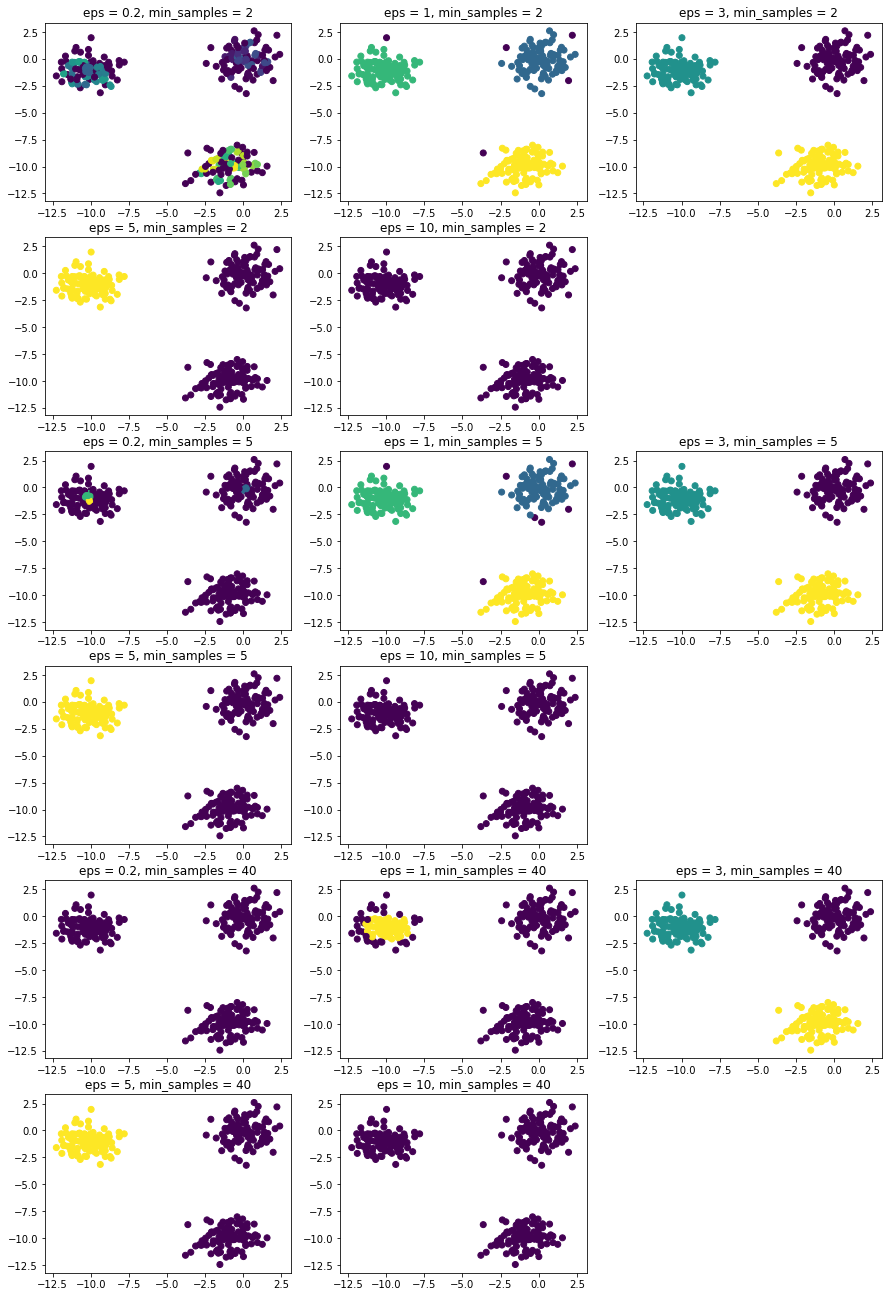

In [8]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

np.random.seed(123)
X1 = np.random.randn(100,2)
X2 = np.random.randn(100,2) - np.array([10,1])
X3 = np.random.randn(100,2) - np.array([1,10])
X = np.vstack((X1,X2,X3))
y = np.array([1]*100 + [2]*100 + [3]*100)
plt.figure(figsize= (15,23))

i = 1
for samples in [2, 5, 40]:
    for e in [0.2, 1, 3, 5, 10]:
        dbscan = DBSCAN(eps=e, min_samples=samples)
        clusters = dbscan.fit_predict(X)
        plt.subplot(6, 3, i)
        plt.scatter(X[:,0], X[:,1], c = clusters)
        plt.title('eps = {}, min_samples = {}'.format(e, samples))
        i += 1
    i+=1

plt.show()

## PCA (Principal Component Analysis)

Также для лучшего поиска аномалий может подойти алгоритм выявления важных признаков.
Выделение новых признаков путем их отбора часто дает плохие результаты, и в некоторых ситуациях такой подход практически бесполезен. Например, если мы работаем с изображениями, у которых признаками являются яркости пикселей, невозможно выбрать небольшой поднабор пикселей, который дает хорошую информацию о содержимом картинки.
Поэтому признаки нужно как-то комбинировать. Рассмотрим метод главных компонент.

Этот метод делает два важных упрощения задачи:
- Игнорируется целевая переменная
- Строится линейная комбинация признаков

П. 1 на первый взгляд кажется довольно странным, но на практике обычно не является таким уж плохим. Это связано с тем, что часто данные устроены так, что имеют какую-то внутреннюю структуру в пространстве меньшей размерности, которая никак не связана с целевой переменной. Поэтому и оптимальные признаки можно строить, не глядя на ответ.

П. 2 тоже сильно упрощает задачу, но можно избавиться от него.

Попробуем специально сделать один из признаков более значимым и проверим, что PCA это обнаружит. Сгенерируем выборку из двухмерного гауссовского распределения.

In [9]:
np.random.seed(314512)

data_synth_1 = np.random.multivariate_normal(
    mean=[0, 0], 
    cov=[[4, 0], 
         [0, 1]],
    size=1000)

Теперь изобразим точки выборки на плоскости и применим к ним PCA для нахождения главных компонент. В результате работы PCA из sklearn в dec.components_ будут лежать главные направления (нормированные), а в dec.explained_variance_ — дисперсия, которую объясняет каждая компонента. Изобразим на нашем графике эти направления, умножив их на дисперсию для наглядного отображения их значимости.

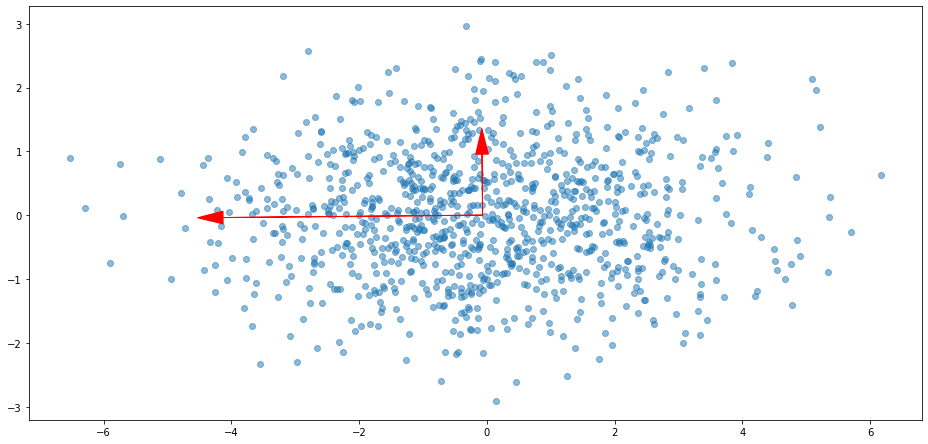

In [10]:
from sklearn.decomposition import PCA


def PCA_show(dataset):
    plt.scatter(*zip(*dataset), alpha=0.5)
    
    dec = PCA()
    dec.fit(dataset)
    ax = plt.gca()
    for comp_ind in range(dec.components_.shape[0]):
        component = dec.components_[comp_ind, :]
        var = dec.explained_variance_[comp_ind]
        start, end = dec.mean_, component * var
        ax.arrow(start[0], start[1], end[0], end[1],
                 head_width=0.2, head_length=0.4, fc='r', ec='r')
    
    ax.set_aspect('equal', adjustable='box')

plt.figure(figsize=(16, 8))
PCA_show(data_synth_1)

## Naïve Bayes classifiers

**Наивный баейсовский классификатор**. Данный алгоритм может быть очень точным. Например, его успешно примененяют для фильтрации спама. Идея заключается в предсказании класса на основании набора параметров, используя вероятность. Для использования в нашей задачи, я предполагаю, что можно использовать результаты интерквантильного размаха и создать 2 класса с некоторым кол-вом "хороших" и "аномальных" сессий, где в качестве параметров будет расстояние до центров кластеров (высокой плотности)

![Imgur](https://i.imgur.com/JFBkXaf.jpg)

![Imgur](https://pp.userapi.com/c637717/v637717210/6838f/h_T-iT7wqbc.jpg)

## AutoEncoder

Хорошим и качественным вариантом может стать использование Автоэнкодера, потому что в работе Джеффри Хинтона (2006г) было показано, что обученный автоэнкодер дает меньшую ошибку по сравнению с первыми 30 основными компонентами PCA и лучшее разделение кластеров.

#### Почему автоэнкодеры?
Уже есть много полезных инструментов, таких как метод главных компонент (PCA), для обнаружения выбросов, зачем нужны автокодеры? PCA использует линейную алгебру. Автоэнкодеры же, могут выполнять нелинейные преобразования с их нелинейной функцией активации и несколькими слоями. Более эффективно тренировать несколько слоев с помощью автоэнкодера, а не тренировать одно огромное преобразование с помощью PCA. Таким образом, методы автоэнкодера могут оказаться очень полезными, особенно, когда данные неравномерные.

Посмотрим на примере обнаружения выбросов точек. 
Входной слой и выходной слой имеют 23 нейронов каждый. Есть два скрытых слоя, каждый имеет два нейрона.

In [11]:
contamination = 0.1  # процент выбросов
n_train = 500
n_test = 500       
n_features = 23 

X_train, y_train, X_test, y_test = generate_data(
    n_train=n_train, n_test=n_test,
    n_features= n_features, 
    contamination=contamination,behaviour="old",random_state=1234)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyod/utils/data.py:186: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.8.0. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  warn('behaviour="old" is deprecated and will be removed '


Стандартизируем предсказание

In [12]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test)

Уменьшим размерность до 2-ух и построим график

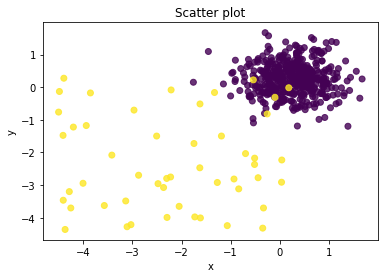

In [13]:
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(X_train)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']

# Plot
import matplotlib.pyplot as plt
plt.scatter(X_train[0], X_train[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Желтые точки - «выбросы», а фиолетовые - «нормальные»

## Шаг 1 — Построение модели

In [14]:
clf1 = AutoEncoder(hidden_neurons =[23, 2, 2, 23])
clf1.fit(X_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 23)                552       
_________________________________________________________________
dropout_1 (Dropout)          (None, 23)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 23)                552       
_________________________________________________________________
dropout_2 (Dropout)          (None, 23)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 23)                552       
_________________________________________________________________
dropout_3 (Dropout)          (None, 23)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

450/450 [==============================] - 0s 99us/step - loss: 3.9667 - val_loss: 4.2147
Epoch 60/100
450/450 [==============================] - 0s 109us/step - loss: 3.8684 - val_loss: 4.1659
Epoch 61/100
450/450 [==============================] - 0s 115us/step - loss: 3.8552 - val_loss: 4.1138
Epoch 62/100
450/450 [==============================] - 0s 108us/step - loss: 3.7792 - val_loss: 4.0683
Epoch 63/100
450/450 [==============================] - 0s 109us/step - loss: 3.7092 - val_loss: 4.0212
Epoch 64/100
450/450 [==============================] - 0s 98us/step - loss: 3.6511 - val_loss: 3.9841
Epoch 65/100
450/450 [==============================] - 0s 106us/step - loss: 3.6330 - val_loss: 3.9398
Epoch 66/100
450/450 [==============================] - 0s 133us/step - loss: 3.5913 - val_loss: 3.8977
Epoch 67/100
450/450 [==============================] - 0s 183us/step - loss: 3.5586 - val_loss: 3.8587
Epoch 68/100
450/450 [==============================] - 0s 166us/step - loss: 3

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[23, 2, 2, 23],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7ff9d5886a60>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

## Шаг 2 — Определение границы

Применим обученную модель Clf1, чтобы предсказать оценку аномалии для каждого наблюдения в тестовых данных. Как определяем выброс? Выброс - это точка, удаленная от других точек, поэтому показатель выброса определяется расстоянием. Функция PyOD .decision_function () вычисляет расстояние или оценку аномалии для каждой точки данных

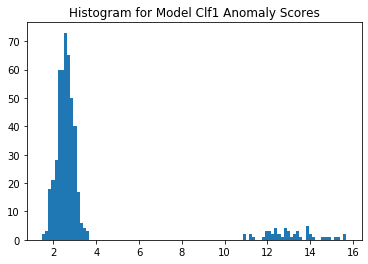

In [15]:
# Получение очков выбросов в train
y_train_scores = clf1.decision_scores_  

# Предсказание очков аномалии
y_test_scores = clf1.decision_function(X_test)  # очки выброса
y_test_scores = pd.Series(y_test_scores)

import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

Высокие очки соответствуют низкой частоте - свидетельство выбросов. Выберем 4.0, для границы, а >= 4.0, для выбросов.

## Шаг 3 — Сводная статистика по кластеру

Присвоим эти наблюдения с менее чем 4,0 баллами аномалий кластеру 0 и кластеру 1 для тех, кто выше 4.0. Рассчитываю сводную статистику по кластерам, используя .groupby()

In [16]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

df_test.groupby('cluster').mean()

0         1         2         3         4         5         6  \
cluster                                                                         
0        0.244639  0.244716  0.250291  0.255489  0.249827  0.242352  0.251128   
1       -2.201748 -2.202442 -2.252619 -2.299398 -2.248445 -2.181169 -2.260155   

                7         8         9  ...        14        15        16  \
cluster                                ...                                 
0        0.243588  0.226969  0.235325  ...  0.265010  0.250412  0.232767   
1       -2.192295 -2.042720 -2.117924  ... -2.385087 -2.253707 -2.094903   

               17        18        19        20        21        22      score  
cluster                                                                         
0        0.262089  0.250051  0.243011  0.250400  0.241229  0.249129   2.551039  
1       -2.358805 -2.250460 -2.187096 -2.253601 -2.171063 -2.242159  13.064981  

[2 rows x 24 columns]

Следующий вывод показывает средние значения переменных в каждом кластере. Значения кластера «1» (ненормальный кластер) весьма отличаются от значений кластера «0» (нормальный кластер). Значения «баллов» показывают среднее расстояние этих наблюдений до других. Высокий «балл» означает, что наблюдение далеко от нормы.

Как применить к нашей задаче автоэнкодэры, я не придумал, потому что если обучать на каждой новой хорошей сессии модель заново, то она ведь не будет подходить для других. С другой стороны если собрать выборку явно плохих сессий и обучить модель на них, то может что то получится вменяемое, но для этой задачи проще и эффективней использовать **наивный баейсовский классификатор**

## Заключение

### Можно выделить необходимые шаги для обнаружение подозрительных сессий с использованием ML

- Шаг 1. Поиск известных моделей мошенничества путем внедрения экспертных знаний: оценка риска мошенничества и ранжирование объектов
        => От случайных проверок к систематическим автоматизированным проверкам и расстановке приоритетов 
        => Интеллектуальный анализ данных для автоматизации обнаружения мошенничества
    
- Шаг 2. Идентификация известных схем мошенничества с помощью машинного обучения и их автоматическое обнаружение в будущем: 
        => Обучение с учителем: автоматическая классификация, регрессия, оценки риска, генерация правил

        
- Шаг 3. Выявление ранее неизвестных случаев или схем мошенничества: обучение без учителя, обнаружение аномалий, обнаружение выбросов 


- Шаг 4. Сравнение с ожиданиями: предсказать итог и сравнить с фактическими данными 


- Шаг 5: Состязательное машинное обучение / Текстовая аналитика / Процесс майнинг 


- Шаг 6: (Полу) Автоматические Аудиты

# Links:
1) Unsupervised learning techniques for fraud detection (GitHub) (https://github.com/DespiteDeath/FraudDetection/blob/master/.ipynb_checkpoints/08_Unsupervised_learning_techniques_for_fraud_detection-checkpoint.ipynb)

2) How to create features in fraud detection (GitHub) (https://github.com/DespiteDeath/FraudDetection/blob/master/03_Feature_engineering_for_fraud_detection.ipynb)

3) Интерквартильный размах (https://medium.com/@congyuzhou/интерквартильный-размах-28604de365a0)

4) DBSCAN (https://habr.com/ru/post/322034/), (https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556)

5) LOF (Local Outlier Factor) (https://www.dbs.ifi.lmu.de/Publikationen/Papers/LOF.pdf), (https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html), (https://ru.wikipedia.org/wiki/%D0%9B%D0%BE%D0%BA%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D1%83%D1%80%D0%BE%D0%B2%D0%B5%D0%BD%D1%8C_%D0%B2%D1%8B%D0%B1%D1%80%D0%BE%D1%81%D0%B0)

6) K means (https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1), (https://en.wikipedia.org/wiki/K-means_clustering)

7) PCA (Метод главных компонент) (https://habr.com/ru/post/304214/), (https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82)

8) Naïve Bayes classifiers (https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c), (https://ru.wikipedia.org/wiki/Наивный_байесовский_классификатор)

9) AutoEncoder (https://towardsdatascience.com/anomaly-detection-with-autoencoder-b4cdce4866a6)

10) SOS (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.13.991&rep=rep1&type=pdf)

11) Kagle fraud detection https://github.com/DespiteDeath/kaggle-fraud-detection